# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [2]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [3]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')
azdias_orig = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';') #load original data set for comparison later

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')
feat_info_orig = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [4]:
# Load data dictionary file
data_dict = open('Data_Dictionary.md').read()

In [5]:
print(data_dict)

# Data Dictionary for Identify Customer Segments Data

## Introduction

The data for this project consist of two files:

- Udacity_AZDIAS_Subset.csv: demographics data for the general population of
      Germany; 891211 persons (rows) x 85 features (columns)
- Udacity_CUSTOMERS_Subset.csv: demographics data for customers of a mail-order
      company; 191652 persons (rows) x 85 features (columns)

The columns in the general demographics file and customers data file are the
same. This file documents the features that appear in the data files, sorted in
order of appearance. Sections of this file is based on the level of measurement
of each feature. The file "AZDIAS_Feature_Summary.csv" contains a summary of
feature attributes, including information level, data type, and codes for
missing or unknown values.

### Table of Contents

 1. Person-level features
 2. Household-level features
 3. Building-level features
 4. RR4 micro-cell features
 5. RR3 micro-cell features
 6. Postcode-level fe

In [6]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [7]:
feat_info.set_index("attribute", inplace=True)
feat_info.head()

,information_level,type,missing_or_unknown
attribute,,,
AGER_TYP,person,categorical,"[-1,0]"
ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
ANREDE_KZ,person,categorical,"[-1,0]"
CJT_GESAMTTYP,person,categorical,[0]
FINANZ_MINIMALIST,person,ordinal,[-1]


In [8]:
feat_info.loc['AGER_TYP']

information_level          person
type                  categorical
missing_or_unknown         [-1,0]
Name: AGER_TYP, dtype: object

In [9]:
missing_unknown_str = feat_info.loc['AGER_TYP'].missing_or_unknown
print(missing_unknown_str)

[-1,0]


In [10]:
for ii in feat_info_orig.index: 
    attribute = feat_info_orig.iloc[ii].attribute
    missing_values_str = feat_info_orig.iloc[ii].missing_or_unknown
    print(attribute, missing_values_str)

AGER_TYP [-1,0]
ALTERSKATEGORIE_GROB [-1,0,9]
ANREDE_KZ [-1,0]
CJT_GESAMTTYP [0]
FINANZ_MINIMALIST [-1]
FINANZ_SPARER [-1]
FINANZ_VORSORGER [-1]
FINANZ_ANLEGER [-1]
FINANZ_UNAUFFAELLIGER [-1]
FINANZ_HAUSBAUER [-1]
FINANZTYP [-1]
GEBURTSJAHR [0]
GFK_URLAUBERTYP []
GREEN_AVANTGARDE []
HEALTH_TYP [-1,0]
LP_LEBENSPHASE_FEIN [0]
LP_LEBENSPHASE_GROB [0]
LP_FAMILIE_FEIN [0]
LP_FAMILIE_GROB [0]
LP_STATUS_FEIN [0]
LP_STATUS_GROB [0]
NATIONALITAET_KZ [-1,0]
PRAEGENDE_JUGENDJAHRE [-1,0]
RETOURTYP_BK_S [0]
SEMIO_SOZ [-1,9]
SEMIO_FAM [-1,9]
SEMIO_REL [-1,9]
SEMIO_MAT [-1,9]
SEMIO_VERT [-1,9]
SEMIO_LUST [-1,9]
SEMIO_ERL [-1,9]
SEMIO_KULT [-1,9]
SEMIO_RAT [-1,9]
SEMIO_KRIT [-1,9]
SEMIO_DOM [-1,9]
SEMIO_KAEM [-1,9]
SEMIO_PFLICHT [-1,9]
SEMIO_TRADV [-1,9]
SHOPPER_TYP [-1]
SOHO_KZ [-1]
TITEL_KZ [-1,0]
VERS_TYP [-1]
ZABEOTYP [-1,9]
ALTER_HH [0]
ANZ_PERSONEN []
ANZ_TITEL []
HH_EINKOMMEN_SCORE [-1,0]
KK_KUNDENTYP [-1]
W_KEIT_KIND_HH [-1,0]
WOHNDAUER_2008 [-1,0]
ANZ_HAUSHALTE_AKTIV [0]
ANZ_HH_TITEL []
GEBAE

In [11]:
feat_info['missing_or_unknown'][56:65]

attribute
WOHNLAGE              [-1]
CAMEO_DEUG_2015     [-1,X]
CAMEO_DEU_2015        [XX]
CAMEO_INTL_2015    [-1,XX]
KBA05_ANTG1           [-1]
KBA05_ANTG2           [-1]
KBA05_ANTG3           [-1]
KBA05_ANTG4           [-1]
KBA05_BAUMAX        [-1,0]
Name: missing_or_unknown, dtype: object

In [12]:
feat_info_orig.iloc[0].attribute

'AGER_TYP'

In [13]:
feat_info_orig.iloc[0].missing_or_unknown

'[-1,0]'

In [14]:
test_list = list(feat_info.iloc[0].missing_or_unknown)
test_list

['[', '-', '1', ',', '0', ']']

In [15]:
test_list = list(feat_info.iloc[57].missing_or_unknown)
test_list

['[', '-', '1', ',', 'X', ']']

In [16]:
missing_values=[]
for kk in range(0,len(test_list)):
    if test_list[kk] not in ['[',']',',']:
        missing_values.append(test_list[kk])    

missing_values2=[] 
counter=0 
while counter < len(missing_values):
    if missing_values[counter]=='-':
        missing_values2.append(missing_values[counter]+missing_values[counter+1])
        counter+=2
    elif missing_values[counter]=='X' or missing_values[counter]=='XX':
        missing_values2.append('-1')
        counter+=1
    else:
        missing_values2.append(missing_values[counter])
        counter+=1

In [17]:
print(missing_values)
print(missing_values2)

['-', '1', 'X']
['-1', '-1']


In [19]:
text = feat_info.iloc[0].missing_or_unknown.split(',')
print(text[0])
print(text[1])

[-1
0]


In [20]:
feat_info.loc[lambda feat_info: feat_info.information_level == 'person', :]

,information_level,type,missing_or_unknown
attribute,,,
AGER_TYP,person,categorical,"[-1,0]"
ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
ANREDE_KZ,person,categorical,"[-1,0]"
CJT_GESAMTTYP,person,categorical,[0]
FINANZ_MINIMALIST,person,ordinal,[-1]
FINANZ_SPARER,person,ordinal,[-1]
FINANZ_VORSORGER,person,ordinal,[-1]
FINANZ_ANLEGER,person,ordinal,[-1]
FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]


In [21]:
print(feat_info)

                      information_level         type missing_or_unknown
attribute                                                              
AGER_TYP                         person  categorical             [-1,0]
ALTERSKATEGORIE_GROB             person      ordinal           [-1,0,9]
ANREDE_KZ                        person  categorical             [-1,0]
CJT_GESAMTTYP                    person  categorical                [0]
FINANZ_MINIMALIST                person      ordinal               [-1]
FINANZ_SPARER                    person      ordinal               [-1]
FINANZ_VORSORGER                 person      ordinal               [-1]
FINANZ_ANLEGER                   person      ordinal               [-1]
FINANZ_UNAUFFAELLIGER            person      ordinal               [-1]
FINANZ_HAUSBAUER                 person      ordinal               [-1]
FINANZTYP                        person  categorical               [-1]
GEBURTSJAHR                      person      numeric            

In [22]:
azdias['AGER_TYP'].unique()

array([-1,  2,  3,  0,  1])

In [23]:
azdias['CAMEO_INTL_2015'].unique()

array([nan, '51', '24', '12', '43', '54', '22', '14', '13', '15', '33',
       '41', '34', '55', '25', '23', '31', '52', '35', '45', '44', '32',
       'XX'], dtype=object)

In [24]:
# unique values in feature 'TITEL_KZ'
# Note: 0 encodes missing or unknown value
azdias['TITEL_KZ'].unique()

array([nan,  0.,  4.,  1.,  3.,  5.,  2.])

In [25]:
miss_unknown_titelkz_percent = (azdias['TITEL_KZ']==0).sum()/len(azdias['TITEL_KZ'])*100
print('Number of features with missing/unknown encoding 0 in TITEL_KZ (%): ', miss_unknown_titelkz_percent)

Number of features with missing/unknown encoding 0 in TITEL_KZ (%):  91.5106354091746


In [59]:
azdias['AGER_TYP'].replace([-1,0], np.nan, inplace=True)
azdias['CAMEO_INTL_2015'].replace([-1,'XX'], np.nan, inplace=True)
#data_application_full['DAYS_LAST_PHONE_CHANGE'].replace(0, np.nan, inplace=True)
#cc['AMT_DRAWINGS_CURRENT'] = cc['AMT_DRAWINGS_CURRENT'].apply(lambda x: np.nan if x < 0 else x)

In [60]:
azdias['AGER_TYP'][:7]

0    NaN
1    NaN
2    NaN
3    2.0
4    NaN
5    3.0
6    NaN
Name: AGER_TYP, dtype: float64

In [61]:
azdias['AGER_TYP'].unique()

array([ nan,   2.,   3.,   1.])

In [62]:
azdias['CAMEO_INTL_2015'].unique()

array([nan, '51', '24', '12', '43', '54', '22', '14', '13', '15', '33',
       '41', '34', '55', '25', '23', '31', '52', '35', '45', '44', '32'], dtype=object)

In [26]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

# print the first few rows of the data set
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [27]:
# print the shape of the data set: (size of data set, number of features)
azdias.shape

(891221, 85)

In [28]:
# print simple statistics for numerical features
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [6]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [12]:
# azdias.dtypes

In [29]:
def count_cardinality(data, cardinality):
    '''
    INPUT: data frame and cardinality
    OUTPUT: Keys of columns where number of unique is smaller than cardinality
    '''
    dummy = [col for col in data.columns if data[col].dropna().unique().size<=cardinality]

    return dummy

In [30]:
cardinality = 1
dummy = count_cardinality(azdias_orig, cardinality)
result_string = "Dummy features with "+str(cardinality)+" entry: "
print(dummy)
print(result_string, len(dummy))

[]
Dummy features with 1 entry:  0


In [31]:
cardinality = 2
dummy = count_cardinality(azdias_orig, cardinality)
result_string = "Dummy features with "+str(cardinality)+" entries: "
print(dummy)
print(result_string, len(dummy))

['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'OST_WEST_KZ']
Dummy features with 2 entries:  4


In [32]:
azdias['ANREDE_KZ'].unique()

array([1, 2])

In [33]:
azdias['GREEN_AVANTGARDE'].unique()

array([0, 1])

In [34]:
azdias[dummy].head()

,ANREDE_KZ,GREEN_AVANTGARDE,SOHO_KZ,OST_WEST_KZ
0,1,0,NaN,NaN
1,2,0,1.0,W
2,2,1,0.0,W
3,2,0,0.0,W
4,1,0,0.0,W


In [35]:
def missing_data(data):
    '''
    INPUT: dataframe
    OUTPUT: dataframe with total number and percentage of missing values
    '''
    total = data.isnull().sum().sort_values(ascending=False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending=False)
    
    return pd.concat([total, percent], axis=1, keys=['total', 'percent'])

In [25]:
missing_data(azdias_orig)[0:15]

,total,percent
KK_KUNDENTYP,584612,65.596749
KBA05_ANTG1,133324,14.959701
KBA05_ANTG2,133324,14.959701
KBA05_ANTG3,133324,14.959701
KBA05_ANTG4,133324,14.959701
KBA05_BAUMAX,133324,14.959701
KBA05_GBZ,133324,14.959701
MOBI_REGIO,133324,14.959701
REGIOTYP,121196,13.598872
KKK,121196,13.598872


In [15]:
# This is before conversion of missing or unknown values, solely based on original NaN values

In [36]:
def cols_with_missing_data(data):
    '''
    INPUT: dataframe
    OUTPUT: keys of columns with missing data
    '''
    #search for columns with missing data values
    cols_with_missing = [col for col in data.columns 
                                 if data[col].isnull().any()]
    return cols_with_missing

In [27]:
cols_with_missing = cols_with_missing_data(azdias_orig)
print(cols_with_missing)
print('Number of columns with missing data values: ', len(cols_with_missing))

['CJT_GESAMTTYP', 'GFK_URLAUBERTYP', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'RETOURTYP_BK_S', 'SOHO_KZ', 'TITEL_KZ', 'ALTER_HH', 'ANZ_PERSONEN', 'ANZ_TITEL', 'HH_EINKOMMEN_SCORE', 'KK_KUNDENTYP', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'GEBAEUDETYP', 'KONSUMNAEHE', 'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'WOHNLAGE', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'CAMEO_INTL_2015', 'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_BAUMAX', 'KBA05_GBZ', 'BALLRAUM', 'EWDICHTE', 'INNENSTADT', 'GEBAEUDETYP_RASTER', 'KKK', 'MOBI_REGIO', 'ONLINE_AFFINITAET', 'REGIOTYP', 'KBA13_ANZAHL_PKW', 'PLZ8_ANTG1', 'PLZ8_ANTG2', 'PLZ8_ANTG3', 'PLZ8_ANTG4', 'PLZ8_BAUMAX', 'PLZ8_HHZ', 'PLZ8_GBZ', 'ARBEIT', 'ORTSGR_KLS9', 'RELAT_AB']
Number of columns with missing data values:  53


In [14]:
# This is before conversion of missing or unknown values, solely based on original NaN values

In [44]:
def data_numeric(data):
    '''
    INPUT: dataframe
    OUTPUT: data with numeric features only 
    '''
    data_numeric = data.select_dtypes(include=['int64', 'float64'])

    return data_numeric

In [45]:
def data_object(data):
    '''
    INPUT: dataframe
    OUTPUT: data with object features only 
    '''
    data_object = data.select_dtypes(include=['object'])

    return data_object

In [46]:
azdias_numeric = data_numeric(azdias_orig)
azdias_object = data_object(azdias_orig)

print('Shape of full azdias data set: ', azdias_orig.shape)
print('Shape of azdias data set with numerical features only: ', azdias_numeric.shape)
print('Shape of azdias data set with object-type features only: ', azdias_object.shape)

Shape of full azdias data set:  (891221, 85)
Shape of azdias data set with numerical features only:  (891221, 81)
Shape of azdias data set with object-type features only:  (891221, 4)


In [31]:
azdias_object.head()

,OST_WEST_KZ,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015
0,NaN,NaN,NaN,NaN
1,W,8,8A,51
2,W,4,4C,24
3,W,2,2A,12
4,W,6,6B,43


In [19]:
one_hot_encoded_ost_west = pd.get_dummies(azdias_object['OST_WEST_KZ'])
one_hot_encoded_ost_west.head()

,O,W
0,0,0
1,0,1
2,0,1
3,0,1
4,0,1


In [22]:
one_hot_encoded_object = pd.get_dummies(azdias_object)
one_hot_encoded_object.head()

,OST_WEST_KZ_O,OST_WEST_KZ_W,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,...,CAMEO_INTL_2015_35,CAMEO_INTL_2015_41,CAMEO_INTL_2015_43,CAMEO_INTL_2015_44,CAMEO_INTL_2015_45,CAMEO_INTL_2015_51,CAMEO_INTL_2015_52,CAMEO_INTL_2015_54,CAMEO_INTL_2015_55,CAMEO_INTL_2015_XX
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
2,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0


In [ ]:
# NOTE: Nan values get encoded as 0 0 (first entry)

In [33]:
ost_west = copy.deepcopy(azdias_object['OST_WEST_KZ'])
ost_west = pd.DataFrame(ost_west)
ost_west.head()

,OST_WEST_KZ
0,NaN
1,W
2,W
3,W
4,W


In [35]:
ost_west.dtypes

OST_WEST_KZ    object
dtype: object

In [21]:
for col in azdias_object.columns:
    print(azdias_object[col].value_counts())

W    629528
O    168545
Name: OST_WEST_KZ, dtype: int64
8    134441
9    108177
6    105874
4    103912
3     86779
2     83231
7     77933
5     55310
1     36212
X       373
Name: CAMEO_DEUG_2015, dtype: int64
6B    56672
8A    52438
4C    47819
2D    35074
3C    34769
7A    34399
3D    34307
8B    33434
4A    33155
8C    30993
9D    28593
9B    27676
9C    24987
7B    24503
9A    20542
2C    19422
8D    17576
6E    16107
2B    15486
5D    14943
6C    14820
2A    13249
5A    12214
1D    11909
1A    10850
3A    10543
5B    10354
5C     9935
7C     9065
4B     9047
4D     8570
3B     7160
6A     6810
9E     6379
6D     6073
6F     5392
7D     5333
4E     5321
1E     5065
7E     4633
1C     4317
5F     4283
1B     4071
5E     3581
XX      373
Name: CAMEO_DEU_2015, dtype: int64
51    133694
41     92336
24     91158
14     62884
43     56672
54     45391
25     39628
22     33155
23     26750
13     26336
45     26132
55     23955
52     20542
31     19024
34     18524
15     16974
44   

In [34]:
# Note: categories 'X' and 'XX' have to be treated as NaNs. 

In [28]:
# "cardinality" means the number of unique values in a column.
# We use it as our only way to select categorical columns here. 
# This is convenient, though a little arbitrary.

cutoff=5

low_cardinality_cols = [cname for cname in azdias.columns if 
                                azdias[cname].nunique() < cutoff and
                                azdias[cname].dtype == "object"]

numeric_cols = [cname for cname in azdias.columns if 
                                azdias[cname].dtype in ['int64', 'float64']]

my_cols = low_cardinality_cols + numeric_cols

X_predictors = azdias[my_cols]
#test_predictors = candidate_test_predictors[my_cols]

print(azdias.shape)
print(X_predictors.shape)

(891221, 85)
(891221, 82)


In [39]:
def keep_low_cardinality_columns(data, cardinality):
    '''
    use this function to remove object-type data whose cardinality is too high
    '''
    cutoff=cardinality

    low_cardinality_cols = [cname for cname in data.columns if 
                                data[cname].nunique() < cutoff and
                                data[cname].dtype == "object"]

    numeric_cols = [cname for cname in data.columns if 
                                data[cname].dtype in ['int64', 'float64']]

    my_cols = low_cardinality_cols + numeric_cols

    X_predictors = data[my_cols]
    
    return X_predictors

In [40]:
def plot_categorical(data, col, size=[8 ,4], xlabel_angle=0, title=''):
    '''
    use this function for ploting histogram, i.e., the count of categorical features
    '''
    plotdata = data[col].value_counts()
    plt.figure(figsize = size)
    sns.barplot(x = plotdata.index, y=plotdata.values)
    plt.title(title)
    if xlabel_angle!=0: 
        plt.xticks(rotation=xlabel_angle)
    plt.show()
    

In [41]:
def plot_numerical(data, col, size=[8, 4], bins=50):
    '''
    use this function for ploting the distribution of numercial features
    '''
    plt.figure(figsize=size)
    plt.title("Distribution of %s" % col)
    sns.distplot(data[col].dropna(), kde=True, bins=bins)
    plt.show()
    

In [42]:
def plot_categorical_bylabel(data, col, size=[12 ,6], xlabel_angle=0, title=''):
    '''
    use it to compare the distribution between label 1 and label 0
    '''
    plt.figure(figsize = size)
    l1 = data.loc[data.TARGET==1, col].value_counts()
    l0 = data.loc[data.TARGET==0, col].value_counts()
    
    plt.subplot(1,2,1)
    sns.barplot(x = l0.index, y=l0.values)
    plt.title('Non-default (Y=0): '+title)
    plt.xticks(rotation=xlabel_angle)
    
    plt.subplot(1,2,2)
    sns.barplot(x = l1.index, y=l1.values)
    plt.title('Default (Y=1): '+title)
    plt.xticks(rotation=xlabel_angle)
    plt.show()
    

In [43]:
def plot_numerical_bylabel(data, col, size=[8, 4], bins=50):
    '''
    use this function to compare the distribution of numercial features
    '''
    plt.figure(figsize=[12, 6])
    l1 = data.loc[data.TARGET==1, col]
    l0 = data.loc[data.TARGET==0, col]
    
    plt.subplot(1,2,1)
    sns.distplot(l0.dropna(), kde=True,bins=bins)
    plt.title('Non-default (Y=0): Distribution of %s' % col)
    
    plt.subplot(1,2,2)
    sns.distplot(l1.dropna(), kde=True,bins=bins)
    plt.title('Default (Y=1): Distribution of %s' % col)
    
    plt.show()

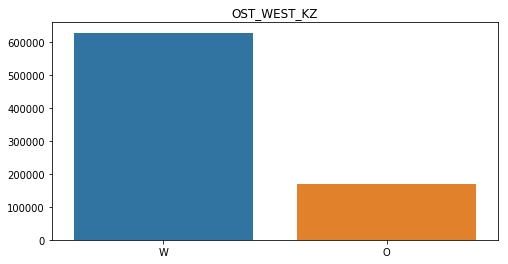

In [36]:
plot_categorical(data=azdias, col='OST_WEST_KZ', size=[8 ,4], xlabel_angle=0, title='OST_WEST_KZ')

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [47]:
# reload and plot header of feature attributes summary. 
# fourth column shows encoding for missing or unknown data
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [48]:
feat_info.set_index("attribute", inplace=True)
feat_info.head()

,information_level,type,missing_or_unknown
attribute,,,
AGER_TYP,person,categorical,"[-1,0]"
ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
ANREDE_KZ,person,categorical,"[-1,0]"
CJT_GESAMTTYP,person,categorical,[0]
FINANZ_MINIMALIST,person,ordinal,[-1]


In [49]:
missing_unknown_str = feat_info.loc['AGER_TYP'].missing_or_unknown
print(missing_unknown_str)

[-1,0]


In [50]:
# function that converts string encoding missing values into list with numerical values (X, XX -> -1)
def miss_str_to_list(miss_unknown_str):
    '''
    INPUT: single string encoding missing and unknown values
    OUTPUT: list containing all encodings as separate entries
    '''
    # split up total string
    test_list = list(miss_unknown_str)
    
    missing_values=[]
    
    # save all relevant entries of list 
    for kk in range(0,len(test_list)):
        if test_list[kk] not in ['[',']',',']:
            missing_values.append(test_list[kk])    
    
    # combine '-' and '1' into '-1' and 'X' 'X' into 'XX'
    missing_values2=[] 
    counter=0 
    while counter < len(missing_values):
        if missing_values[counter]=='-':
            missing_values2.append(missing_values[counter]+missing_values[counter+1])
            counter+=2
        elif missing_values[counter]=='X' and counter <(len(missing_values)-1):
            if missing_values[counter+1]=='X':
                missing_values2.append(missing_values[counter]+missing_values[counter+1])
                counter+=2
            else:
                missing_values2.append(missing_values[counter])
                counter+=1
        else:
            missing_values2.append(missing_values[counter])
            counter+=1
    
    # replace str by int if possible
    for ii in range(0,len(missing_values2)):
        if missing_values2[ii] in ['-1', '0', '9']:
            missing_values2[ii]=int(missing_values2[ii])
           
    return missing_values2

In [51]:
# Identify missing or unknown data values and convert them to NaNs.
for key in azdias.keys():
    # get string encoding from feat_info
    miss_unknown_str = feat_info.loc[key].missing_or_unknown
    # convert string into list
    missing_unknown_values = miss_str_to_list(miss_unknown_str)
    # replace with NaN
    if len(missing_unknown_values)>0:
        azdias[key].replace(missing_unknown_values, np.nan, inplace=True)

In [52]:
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,205378.000000,888340.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,793846.000000,793947.000000,793846.000000
mean,1.743410,2.757217,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.166686,5.293389,3.071033
std,0.674312,1.009951,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,0.999072,2.303379,1.360532
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.000000
50%,2.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.000000
75%,2.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.000000
max,3.000000,4.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,5.000000,9.000000,5.000000


In [53]:
# azdias data set AFTER conversion
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [54]:
# original azdias data set BEFORE conversion
azdias_orig.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [55]:
missing_data(azdias)[0:15]

,total,percent
TITEL_KZ,889061,99.757636
AGER_TYP,685843,76.955435
KK_KUNDENTYP,584612,65.596749
KBA05_BAUMAX,476524,53.468668
GEBURTSJAHR,392318,44.020282
ALTER_HH,310267,34.813699
REGIOTYP,158064,17.735668
KKK,158064,17.735668
W_KEIT_KIND_HH,147988,16.605084
KBA05_ANTG4,133324,14.959701


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [56]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
missing_data(azdias)[0:15]

,total,percent
TITEL_KZ,889061,99.757636
AGER_TYP,685843,76.955435
KK_KUNDENTYP,584612,65.596749
KBA05_BAUMAX,476524,53.468668
GEBURTSJAHR,392318,44.020282
ALTER_HH,310267,34.813699
REGIOTYP,158064,17.735668
KKK,158064,17.735668
W_KEIT_KIND_HH,147988,16.605084
KBA05_ANTG4,133324,14.959701


In [57]:
missing_data(azdias)

,total,percent
TITEL_KZ,889061,99.757636
AGER_TYP,685843,76.955435
KK_KUNDENTYP,584612,65.596749
KBA05_BAUMAX,476524,53.468668
GEBURTSJAHR,392318,44.020282
ALTER_HH,310267,34.813699
REGIOTYP,158064,17.735668
KKK,158064,17.735668
W_KEIT_KIND_HH,147988,16.605084
KBA05_ANTG4,133324,14.959701


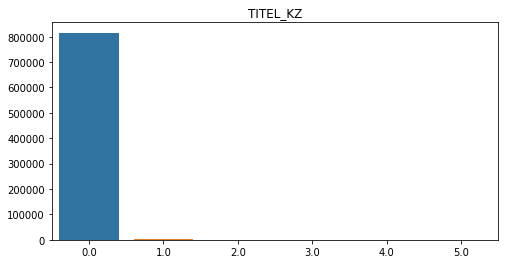

[-1,0]


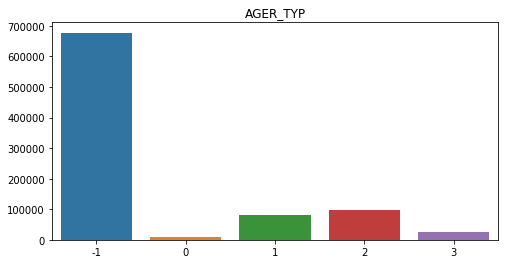

[-1,0]


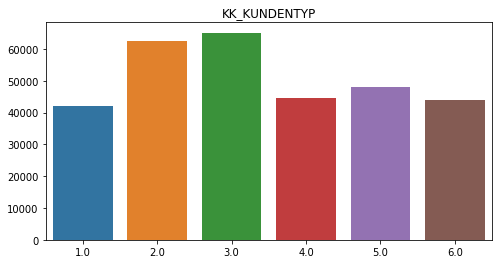

[-1]


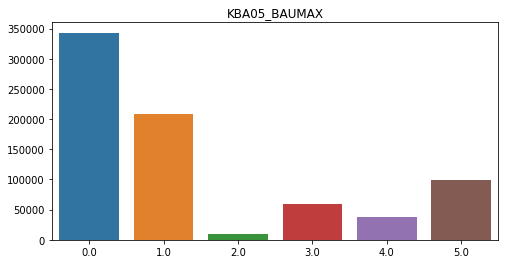

[-1,0]


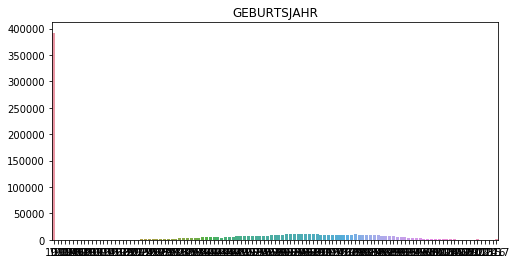

[0]


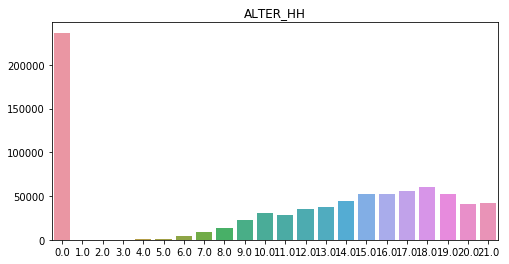

[0]


In [39]:
# Investigate patterns in the amount of missing data in each column.
plot_categorical(data=azdias_orig, col='TITEL_KZ', size=[8 ,4], xlabel_angle=0, title='TITEL_KZ')
print(feat_info.loc['TITEL_KZ'].missing_or_unknown)
plot_categorical(data=azdias_orig, col='AGER_TYP', size=[8 ,4], xlabel_angle=0, title='AGER_TYP')
print(feat_info.loc['AGER_TYP'].missing_or_unknown)
plot_categorical(data=azdias_orig, col='KK_KUNDENTYP', size=[8 ,4], xlabel_angle=0, title='KK_KUNDENTYP')
print(feat_info.loc['KK_KUNDENTYP'].missing_or_unknown)
plot_categorical(data=azdias_orig, col='KBA05_BAUMAX', size=[8 ,4], xlabel_angle=0, title='KBA05_BAUMAX')
print(feat_info.loc['KBA05_BAUMAX'].missing_or_unknown)
plot_categorical(data=azdias_orig, col='GEBURTSJAHR', size=[8 ,4], xlabel_angle=0, title='GEBURTSJAHR')
print(feat_info.loc['GEBURTSJAHR'].missing_or_unknown)
plot_categorical(data=azdias_orig, col='ALTER_HH', size=[8 ,4], xlabel_angle=0, title='ALTER_HH')
print(feat_info.loc['ALTER_HH'].missing_or_unknown)

In [37]:
# feature KK_KUNDENTYP contains large fraction of NaN values in original data set, already, i.e. before encoding. 
# For the other features displayed above large fration of NaN values becomes evident after encoding (of 0 and -1 values)

In [46]:
# detect features where large fraction of values are missing
nan_threshold = 0.1
outliers = [key for key in azdias.keys() if azdias[key].isnull().sum()/len(azdias[key]) > nan_threshold]
print(outliers)
print(len(outliers))

['AGER_TYP', 'GEBURTSJAHR', 'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE', 'SHOPPER_TYP', 'TITEL_KZ', 'VERS_TYP', 'ALTER_HH', 'KK_KUNDENTYP', 'W_KEIT_KIND_HH', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'GEBAEUDETYP', 'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'WOHNLAGE', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'CAMEO_INTL_2015', 'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_BAUMAX', 'KBA05_GBZ', 'BALLRAUM', 'EWDICHTE', 'INNENSTADT', 'GEBAEUDETYP_RASTER', 'KKK', 'MOBI_REGIO', 'REGIOTYP', 'KBA13_ANZAHL_PKW', 'PLZ8_ANTG1', 'PLZ8_ANTG2', 'PLZ8_ANTG3', 'PLZ8_ANTG4', 'PLZ8_BAUMAX', 'PLZ8_HHZ', 'PLZ8_GBZ', 'ARBEIT', 'ORTSGR_KLS9', 'RELAT_AB']
46


In [58]:
# detect features where large fraction of values are missing
nan_threshold = 0.2
outliers = [key for key in azdias.keys() if azdias[key].isnull().sum()/len(azdias[key]) > nan_threshold]
print(outliers)
print(len(outliers))

['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
6


In [59]:
azdias[outliers].head()

,AGER_TYP,GEBURTSJAHR,TITEL_KZ,ALTER_HH,KK_KUNDENTYP,KBA05_BAUMAX
0,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1996.0,NaN,NaN,NaN,5.0
2,NaN,1979.0,NaN,17.0,NaN,NaN
3,2.0,1957.0,NaN,13.0,NaN,1.0
4,NaN,1963.0,NaN,20.0,1.0,NaN


In [60]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

# azdias_drop = azdias.drop(columns=outliers)
azdias_drop = azdias.drop(outliers, axis=1)
print('Shape of original data set: ', azdias_orig.shape)
print('Shape of data set w/o outlier columns: ', azdias_drop.shape)

Shape of original data set:  (891221, 85)
Shape of data set w/o outlier columns:  (891221, 79)


In [116]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

# azdias_drop = azdias.drop(columns=outliers)
azdias_drop = azdias.drop(outliers, axis=1)
print('Shape of original data set: ', azdias_orig.shape)
print('Shape of data set w/o outlier columns: ', azdias_drop.shape)

Shape of original data set:  (891221, 85)
Shape of data set w/o outlier columns:  (891221, 80)


In [117]:
if 'subset' in azdias_drop.keys():
    azdias_drop = azdias_drop.drop(['subset'], axis=1)

In [118]:
'subset' in azdias_drop.keys()

False

In [63]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [119]:
azdias_drop.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Discussion 1.1.2: Assess Missing Data in Each Column

(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)

The following features cotain a large fration of missing data: 
- TITEL_KZ: academic title -> few people have an academic title. 
- AGER_TYP: best-ager typology. 
- KK_KUNDENTYP: consumer pattern over last 12 months. 
- KBA05_BAUMAX: this feature of a larger group of features KBA... (microcell) where many data are missing. 
- GEBURTSJAHR: year of birth. 
- ALTER_HH: birthdate of head of household. -> There are few data on year of birth in general (GEBURTSJAHR). 

In the KBA... feature group (microcell features) about 15% of all data are missing. Similarly, in the PLZ8... feature group (macrocell features) about 13% of values are msiing. Both feature groups appear to be aggregate data. 

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [55]:
# How much data is missing in each row of the dataset?
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [65]:
def missing_data_rows(data):
    '''
    INPUT: dataframe
    OUTPUT: dataframe with total number and percentage of missing values per row
    '''
    
    missing_values_row_abs = data.isnull().sum(axis=1)
    missing_values_row_percent = (data.isnull().sum(axis=1)/data.shape[1])*100
    missing_values_row = pd.concat([missing_values_row_abs, missing_values_row_percent], axis=1, keys=['total', 'percent'])
    # missing_values_row.head()
    
    return missing_values_row

In [85]:
def missing_data_rows2(data, nan_threshold_percent):
    '''
    INPUT: dataframe
    OUTPUT: dataframe with total number, percentage of missing values per row and subset label
    '''
    nan_threshold_percent = nan_threshold_percent
    
    missing_values_row_abs = data.isnull().sum(axis=1)
    missing_values_row_percent = (data.isnull().sum(axis=1)/data.shape[1])*100
    missing_values_row = pd.concat([missing_values_row_abs, missing_values_row_percent], axis=1, keys=['total', 'percent'])
    missing_values_row['subset'] = [1 if x >= nan_threshold_percent else 0 for x in missing_values_row['percent']]
    
    data['subset'] = missing_values_row['subset']
    
    return missing_values_row, data

In [66]:
missing_values_row = missing_data_rows(azdias)
missing_values_row.head()

,total,percent
0,49,57.647059
1,4,4.705882
2,4,4.705882
3,9,10.588235
4,3,3.529412


In [68]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
nan_threshold_percent = 20
missing_values_row['subset'] = [1 if x >= nan_threshold_percent else 0 for x in missing_values_row['percent']]
missing_values_row.head()

,total,percent,subset
0,49,57.647059,1
1,4,4.705882,0
2,4,4.705882,0
3,9,10.588235,0
4,3,3.529412,0


In [69]:
# subgroup below NaN threshold
low0 = missing_values_row.loc[missing_values_row.subset==0]
low0.head()

,total,percent,subset
1,4,4.705882,0
2,4,4.705882,0
3,9,10.588235,0
4,3,3.529412,0
5,2,2.352941,0


In [71]:
missing_values_row.sort_values(by=['percent'], ascending=False)

,total,percent,subset
732775,54,63.529412,1
582372,53,62.352941,1
33158,53,62.352941,1
167341,53,62.352941,1
56204,53,62.352941,1
99965,53,62.352941,1
812953,53,62.352941,1
507593,53,62.352941,1
812946,53,62.352941,1
507607,53,62.352941,1


In [87]:
nan_threshold_percent=20
missing_values_row2, data_incl_subset = missing_data_rows2(azdias,nan_threshold_percent)

In [88]:
missing_values_row2.head()

,total,percent,subset
0,49,57.647059,1
1,4,4.705882,0
2,4,4.705882,0
3,9,10.588235,0
4,3,3.529412,0


In [89]:
data_incl_subset.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,subset
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0,0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,0


In [72]:
print('Number in subset with large number of missing values: ', missing_values_row['subset'].sum())
print('Percent in subset with large number of missing values: ', (missing_values_row['subset'].sum()/len(missing_values_row['subset']))*100)

Number in subset with large number of missing values:  107876
Percent in subset with large number of missing values:  12.104292874606859


In [ ]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

In [60]:
azdias['subset'] = missing_values_row['subset']

In [61]:
def plot_categorical_bygroup(data, col, size=[12 ,6], xlabel_angle=0, title=''):
    '''
    use it to compare the distribution between subset 1 and subset 0
    '''
    
    s0 = data.loc[data.subset==0, col].value_counts()
    s1 = data.loc[data.subset==1, col].value_counts()
    
    plt.figure(figsize = size)
    
    plt.subplot(1,2,1)
    sns.barplot(x = s0.index, y=s0.values)
    plt.title('subgroup 0: Few NaNs')
    plt.xticks(rotation=xlabel_angle)
    
    plt.subplot(1,2,2)
    sns.barplot(x = s1.index, y=s1.values)
    plt.title('subgroup 1: Many NaNs')
    plt.xticks(rotation=xlabel_angle)
    plt.show()    

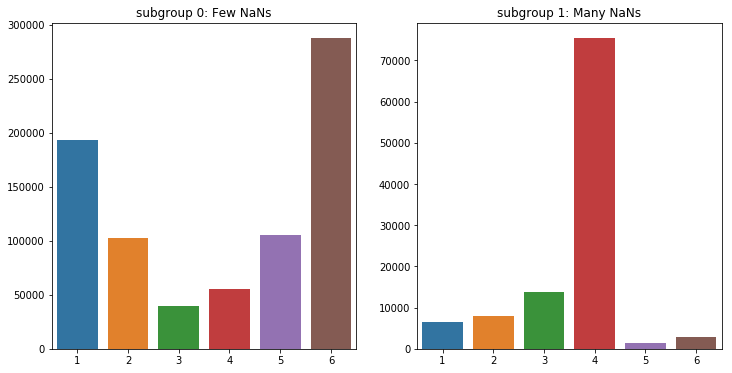

In [62]:
plot_categorical_bygroup(azdias, 'FINANZTYP')

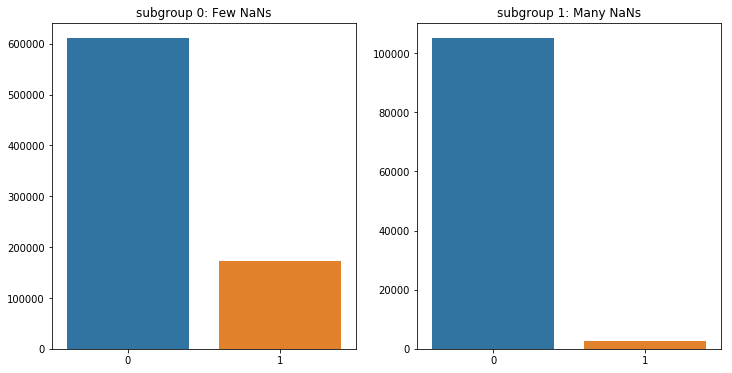

In [63]:
plot_categorical_bygroup(azdias, 'GREEN_AVANTGARDE')

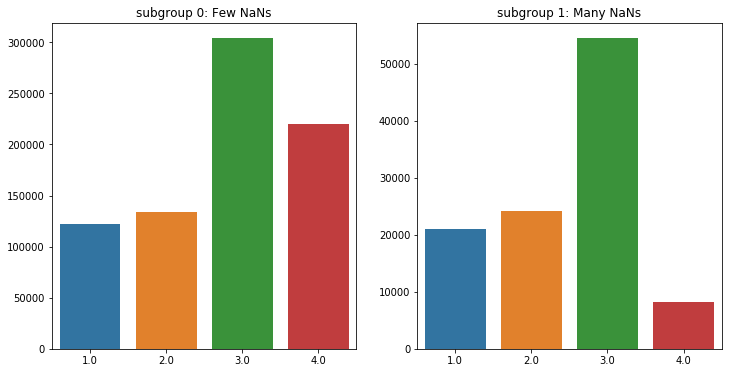

In [64]:
plot_categorical_bygroup(azdias, 'ALTERSKATEGORIE_GROB')

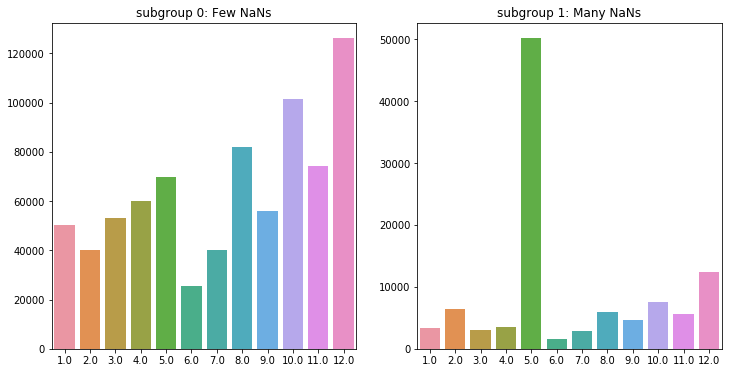

In [65]:
plot_categorical_bygroup(azdias, 'GFK_URLAUBERTYP')

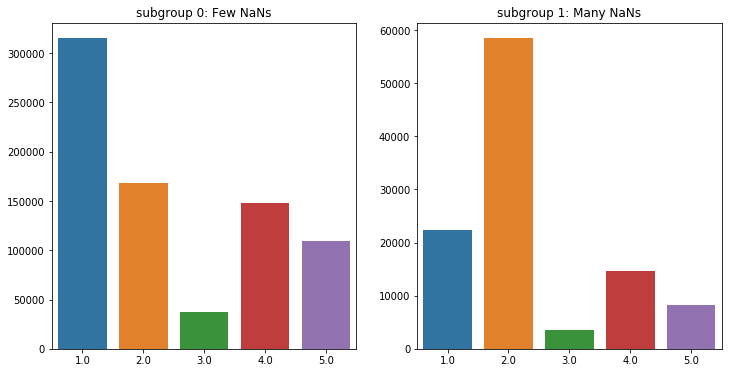

In [66]:
plot_categorical_bygroup(azdias, 'LP_STATUS_GROB')

#### Discussion 1.1.3: Assess Missing Data in Each Row

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)

Conclusion from these plots: The data with many missing values looks very different from the data with few or no missing values. There are obvious qualitative differences. Dropping those points from the analysis shoud present a major issue, because we lose information. 

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [90]:
# How many features are there of each data type?
feat_info_orig.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [91]:
feat_info_orig.shape

(85, 4)

In [92]:
feat_info_orig['type'].unique()

array(['categorical', 'ordinal', 'numeric', 'mixed', 'interval'],
      dtype=object)

In [76]:
number_features_categorical=(feat_info_orig['type']=='categorical').sum()
number_features_ordinal=(feat_info_orig['type']=='ordinal').sum()
number_features_mixed=(feat_info_orig['type']=='mixed').sum()
number_features_numeric=(feat_info_orig['type']=='numeric').sum()
number_features_interval=(feat_info_orig['type']=='interval').sum()
# check if sum of all features adds up to 85
number_features_total = (number_features_categorical + number_features_ordinal 
                         + number_features_mixed + number_features_numeric + number_features_interval)

In [77]:
print('Number of numeric features: ', number_features_numeric)
print('Number of ordinal features: ', number_features_ordinal)
print('Number of categorical features: ', number_features_categorical)
print('Number of mixed features: ', number_features_mixed)
print('Number of interval features: ', number_features_interval)
print('Number of all features: ', number_features_total)

Number of numeric features:  7
Number of ordinal features:  49
Number of categorical features:  21
Number of mixed features:  7
Number of interval features:  1
Number of all features:  85


In [ ]:
# careful: In pandas all features are either numeric (int64, float64) or simply object

In [78]:
azdias_numeric = data_numeric(azdias_orig)
azdias_object = data_object(azdias_orig)

print('Shape of full azdias data set: ', azdias_orig.shape)
print('Shape of azdias data set with numerical features only: ', azdias_numeric.shape)
print('Shape of azdias data set with object-type features only: ', azdias_object.shape)

Shape of full azdias data set:  (891221, 85)
Shape of azdias data set with numerical features only:  (891221, 81)
Shape of azdias data set with object-type features only:  (891221, 4)


In [73]:
# get lists of keys for different feature categories

In [79]:
feat_info_orig[['attribute','type']].head()

,attribute,type
0,AGER_TYP,categorical
1,ALTERSKATEGORIE_GROB,ordinal
2,ANREDE_KZ,categorical
3,CJT_GESAMTTYP,categorical
4,FINANZ_MINIMALIST,ordinal


In [80]:
feat_info.head()

,information_level,type,missing_or_unknown
attribute,,,
AGER_TYP,person,categorical,"[-1,0]"
ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
ANREDE_KZ,person,categorical,"[-1,0]"
CJT_GESAMTTYP,person,categorical,[0]
FINANZ_MINIMALIST,person,ordinal,[-1]


In [81]:
features_categorical = list(feat_info_orig[feat_info_orig.type=='categorical'].attribute)
features_ordinal = list(feat_info_orig[feat_info_orig.type=='ordinal'].attribute)
features_mixed = list(feat_info_orig[feat_info_orig.type=='mixed'].attribute)
features_numeric = list(feat_info_orig[feat_info_orig.type=='numeric'].attribute)
features_interval = list(feat_info_orig[feat_info_orig.type=='interval'].attribute)

In [82]:
print(len(features_categorical))
print(len(features_ordinal))
print(len(features_mixed))
print(len(features_numeric))
print(len(features_interval))

21
49
7
7
1


In [83]:
print('Mixed features: ', features_mixed)

Mixed features:  ['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'PRAEGENDE_JUGENDJAHRE', 'WOHNLAGE', 'CAMEO_INTL_2015', 'KBA05_BAUMAX', 'PLZ8_BAUMAX']


In [84]:
print('Categorical features: ', features_categorical)

Categorical features:  ['AGER_TYP', 'ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'SOHO_KZ', 'TITEL_KZ', 'VERS_TYP', 'ZABEOTYP', 'KK_KUNDENTYP', 'GEBAEUDETYP', 'OST_WEST_KZ', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [ ]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?


In [93]:
# categorical features before NaN encoding and dropping some columns
azdias_orig[features_categorical].head()

,AGER_TYP,ANREDE_KZ,CJT_GESAMTTYP,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,...,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,KK_KUNDENTYP,GEBAEUDETYP,OST_WEST_KZ,CAMEO_DEUG_2015,CAMEO_DEU_2015
0,-1,1,2.0,4,10.0,0,2.0,2.0,1.0,1.0,...,-1,NaN,NaN,-1,3,NaN,NaN,NaN,NaN,NaN
1,-1,2,5.0,1,10.0,0,5.0,3.0,2.0,1.0,...,3,1.0,0.0,2,5,NaN,8.0,W,8,8A
2,-1,2,3.0,1,10.0,1,1.0,1.0,3.0,2.0,...,2,0.0,0.0,1,5,NaN,1.0,W,4,4C
3,2,2,2.0,6,1.0,0,0.0,0.0,9.0,4.0,...,1,0.0,0.0,1,3,NaN,1.0,W,2,2A
4,-1,1,5.0,5,5.0,0,10.0,5.0,3.0,2.0,...,2,0.0,0.0,2,4,1.0,1.0,W,6,6B


In [94]:
# consider data where some columns (with large number of missing values) have been dropped already
# some categorical features may have been dropped already
azdias_drop.keys()

Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP',
       'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
       'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER',
       'FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'HEALTH_TYP',
       'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_FAMILIE_FEIN',
       'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB',
       'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE', 'RETOURTYP_BK_S',
       'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT',
       'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT',
       'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV',
       'SHOPPER_TYP', 'SOHO_KZ', 'VERS_TYP', 'ZABEOTYP', 'ANZ_PERSONEN',
       'ANZ_TITEL', 'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'GEBAEUDETYP', 'KONSUMNAEHE',
       'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'WOHNLAGE', 'CAMEO_DEUG_2015',
       'CAMEO

In [95]:
# example: feature AGER_TYP has been dropped because of an excessive number of NaN values
'AGER_TYP' in azdias_drop.keys()

False

In [96]:
azdias_drop.describe()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,888340.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,793846.000000,793947.000000,793846.000000
mean,2.757217,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,3.790586,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.166686,5.293389,3.071033
std,1.009951,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,1.987876,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,0.999072,2.303379,1.360532
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.000000
50%,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.000000
75%,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,6.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.000000
max,4.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,6.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,5.000000,9.000000,5.000000


In [97]:
features_categorical_drop_binary = []
features_categorical_drop_multilevel = []

for key in features_categorical:
    if key in azdias_drop.keys():
        if len(azdias_drop[key].dropna().unique())==2:
            features_categorical_drop_binary.append(key)   
        else:
            features_categorical_drop_multilevel.append(key)

print('Catgorical (binary) features:\n', features_categorical_drop_binary)            
print('Catgorical (multi-level) features:\n', features_categorical_drop_multilevel)            

Catgorical (binary) features:
 ['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']
Catgorical (multi-level) features:
 ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


In [98]:
print('Number of categorical (binary) features: ', len(features_categorical_drop_binary))            
print('Number of categorical (multi-level) features: ', len(features_categorical_drop_multilevel))

Number of categorical (binary) features:  5
Number of categorical (multi-level) features:  13


In [99]:
# Binary features: encoding
for key in features_categorical_drop_binary:
    print(key, azdias_drop[key].dropna().unique())

ANREDE_KZ [1 2]
GREEN_AVANTGARDE [0 1]
SOHO_KZ [1. 0.]
VERS_TYP [2. 1.]
OST_WEST_KZ ['W' 'O']


In [100]:
# NOTE: the feature OST_WEST_KZ takes on non-numeric values and needs to be recoded
azdias_drop['OST_WEST_KZ'].head()

0    NaN
1      W
2      W
3      W
4      W
Name: OST_WEST_KZ, dtype: object

In [101]:
azdias_drop['OST_WEST_KZ'].replace('W', 0, inplace=True)
azdias_drop['OST_WEST_KZ'].replace('O', 1, inplace=True)
azdias_drop['OST_WEST_KZ'].head()

0    NaN
1    0.0
2    0.0
3    0.0
4    0.0
Name: OST_WEST_KZ, dtype: float64

In [102]:
azdias_drop['OST_WEST_KZ'].unique()

array([nan,  0.,  1.])

In [ ]:
# Re-encode categorical variable(s) to be kept in the analysis.


In [103]:
for key in features_categorical_drop_multilevel:
    print(key, azdias_drop[key].dropna().unique())

CJT_GESAMTTYP [2. 5. 3. 4. 1. 6.]
FINANZTYP [4 1 6 5 2 3]
GFK_URLAUBERTYP [10.  1.  5. 12.  9.  3.  8. 11.  4.  2.  7.  6.]
LP_FAMILIE_FEIN [ 2.  5.  1. 10.  7. 11.  3.  8.  4.  6.  9.]
LP_FAMILIE_GROB [2. 3. 1. 5. 4.]
LP_STATUS_FEIN [ 1.  2.  3.  9.  4. 10.  5.  8.  6.  7.]
LP_STATUS_GROB [1. 2. 4. 5. 3.]
NATIONALITAET_KZ [1. 3. 2.]
SHOPPER_TYP [3. 2. 1. 0.]
ZABEOTYP [3 5 4 1 6 2]
GEBAEUDETYP [8. 1. 3. 2. 6. 4. 5.]
CAMEO_DEUG_2015 ['8' '4' '2' '6' '1' '9' '5' '7' '3']
CAMEO_DEU_2015 ['8A' '4C' '2A' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '5C' '8B' '7A' '5D'
 '9E' '9B' '1B' '3D' '4E' '4B' '3C' '5A' '7B' '9A' '6D' '6E' '2C' '7C'
 '9C' '7D' '5E' '1D' '8D' '6C' '6A' '5B' '4D' '3A' '2B' '7E' '3B' '6F'
 '5F' '1C']


In [202]:
# For simplicity, we keep the binary categorical features (with all of them transformed to numeric values) 
# and we drop the categorical multilevel features. 

In [124]:
azdias_drop.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [125]:
# drop categorical multi-level features
azdias_drop = azdias_drop.drop(features_categorical_drop_multilevel, axis=1)

In [126]:
azdias_drop.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,3,4,3,5,5,3,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2,1,5,2,5,4,5,0,3.0,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,4,2,5,2,1,2,0,2.0,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

Findings and decisions regarding categorical features:
- There are 5 binary categorical features one of which (OST_WEST_KZ) I have re-encoded to numerical values. 
- There are 13 binary categorical features. To keep things straightforward I have just dropped them from the analysis.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [215]:
print(data_dict)

# Data Dictionary for Identify Customer Segments Data

## Introduction

The data for this project consist of two files:

- Udacity_AZDIAS_Subset.csv: demographics data for the general population of
      Germany; 891211 persons (rows) x 85 features (columns)
- Udacity_CUSTOMERS_Subset.csv: demographics data for customers of a mail-order
      company; 191652 persons (rows) x 85 features (columns)

The columns in the general demographics file and customers data file are the
same. This file documents the features that appear in the data files, sorted in
order of appearance. Sections of this file is based on the level of measurement
of each feature. The file "AZDIAS_Feature_Summary.csv" contains a summary of
feature attributes, including information level, data type, and codes for
missing or unknown values.

### Table of Contents

 1. Person-level features
 2. Household-level features
 3. Building-level features
 4. RR4 micro-cell features
 5. RR3 micro-cell features
 6. Postcode-level fe

In [144]:
print('Mixed features: \n', features_mixed)

Mixed features: 
 ['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'PRAEGENDE_JUGENDJAHRE', 'WOHNLAGE', 'CAMEO_INTL_2015', 'KBA05_BAUMAX', 'PLZ8_BAUMAX']


In [145]:
import copy
features_mixed_dropped = copy.deepcopy(features_mixed)
features_mixed_dropped.remove('PRAEGENDE_JUGENDJAHRE')
features_mixed_dropped.remove('CAMEO_INTL_2015')
print('Mixed features (to be dropped): \n', features_mixed_dropped)

Mixed features (to be dropped): 
 ['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'WOHNLAGE', 'KBA05_BAUMAX', 'PLZ8_BAUMAX']


In [ ]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.


In [109]:
print(np.sort(azdias_drop['PRAEGENDE_JUGENDJAHRE'].unique()))

[  1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.  15.
  nan]


In [219]:
# PJ: movement
mainstream = [1, 3, 5, 8, 10, 12, 14]
avant = [2, 4, 6, 7, 9, 11, 13, 15]

In [110]:
conditions = [
    (azdias_drop['PRAEGENDE_JUGENDJAHRE'] == 1),
    (azdias_drop['PRAEGENDE_JUGENDJAHRE'] == 2),
    (azdias_drop['PRAEGENDE_JUGENDJAHRE'] == 3),
    (azdias_drop['PRAEGENDE_JUGENDJAHRE'] == 4),
    (azdias_drop['PRAEGENDE_JUGENDJAHRE'] == 5),
    (azdias_drop['PRAEGENDE_JUGENDJAHRE'] == 6),
    (azdias_drop['PRAEGENDE_JUGENDJAHRE'] == 7),
    (azdias_drop['PRAEGENDE_JUGENDJAHRE'] == 8),
    (azdias_drop['PRAEGENDE_JUGENDJAHRE'] == 9),
    (azdias_drop['PRAEGENDE_JUGENDJAHRE'] == 10),
    (azdias_drop['PRAEGENDE_JUGENDJAHRE'] == 11),
    (azdias_drop['PRAEGENDE_JUGENDJAHRE'] == 12),
    (azdias_drop['PRAEGENDE_JUGENDJAHRE'] == 13),
    (azdias_drop['PRAEGENDE_JUGENDJAHRE'] == 14),
    (azdias_drop['PRAEGENDE_JUGENDJAHRE'] == 15)]
choices = [0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1]
azdias_drop['PJ_move'] = np.select(conditions, choices, default=np.nan)
# azdias_drop['PJ_move'].head()

In [111]:
azdias_drop[['PRAEGENDE_JUGENDJAHRE', 'PJ_move']].head()

,PRAEGENDE_JUGENDJAHRE,PJ_move
0,NaN,NaN
1,14.0,0.0
2,15.0,1.0
3,8.0,0.0
4,8.0,0.0


In [112]:
# PJ: decade
decade1 = [1, 2]
decade2 = [3, 4]
decade3 = [5, 6, 7]
decade4 = [8, 9]
decade4 = [10, 11, 12, 13]
decade5 = [14, 15]

In [113]:
conditions = [
    (azdias_drop['PRAEGENDE_JUGENDJAHRE'] == 1),
    (azdias_drop['PRAEGENDE_JUGENDJAHRE'] == 2),
    (azdias_drop['PRAEGENDE_JUGENDJAHRE'] == 3),
    (azdias_drop['PRAEGENDE_JUGENDJAHRE'] == 4),
    (azdias_drop['PRAEGENDE_JUGENDJAHRE'] == 5),
    (azdias_drop['PRAEGENDE_JUGENDJAHRE'] == 6),
    (azdias_drop['PRAEGENDE_JUGENDJAHRE'] == 7),
    (azdias_drop['PRAEGENDE_JUGENDJAHRE'] == 8),
    (azdias_drop['PRAEGENDE_JUGENDJAHRE'] == 9),
    (azdias_drop['PRAEGENDE_JUGENDJAHRE'] == 10),
    (azdias_drop['PRAEGENDE_JUGENDJAHRE'] == 11),
    (azdias_drop['PRAEGENDE_JUGENDJAHRE'] == 12),
    (azdias_drop['PRAEGENDE_JUGENDJAHRE'] == 13),
    (azdias_drop['PRAEGENDE_JUGENDJAHRE'] == 14),
    (azdias_drop['PRAEGENDE_JUGENDJAHRE'] == 15)]
choices = [0, 0, 1, 1, 2, 2, 2, 3, 3, 4, 4, 4, 4, 5, 5]
azdias_drop['PJ_decade'] = np.select(conditions, choices, default=np.nan)

In [114]:
azdias_drop[['PRAEGENDE_JUGENDJAHRE', 'PJ_decade']].head()

,PRAEGENDE_JUGENDJAHRE,PJ_decade
0,NaN,NaN
1,14.0,5.0
2,15.0,5.0
3,8.0,3.0
4,8.0,3.0


In [121]:
azdias_drop[['PRAEGENDE_JUGENDJAHRE', 'PJ_move', 'PJ_decade']].head()

,PRAEGENDE_JUGENDJAHRE,PJ_move,PJ_decade
0,NaN,NaN,NaN
1,14.0,0.0,5.0
2,15.0,1.0,5.0
3,8.0,0.0,3.0
4,8.0,0.0,3.0


In [ ]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.


In [239]:
print(data_dict)

# Data Dictionary for Identify Customer Segments Data

## Introduction

The data for this project consist of two files:

- Udacity_AZDIAS_Subset.csv: demographics data for the general population of
      Germany; 891211 persons (rows) x 85 features (columns)
- Udacity_CUSTOMERS_Subset.csv: demographics data for customers of a mail-order
      company; 191652 persons (rows) x 85 features (columns)

The columns in the general demographics file and customers data file are the
same. This file documents the features that appear in the data files, sorted in
order of appearance. Sections of this file is based on the level of measurement
of each feature. The file "AZDIAS_Feature_Summary.csv" contains a summary of
feature attributes, including information level, data type, and codes for
missing or unknown values.

### Table of Contents

 1. Person-level features
 2. Household-level features
 3. Building-level features
 4. RR4 micro-cell features
 5. RR3 micro-cell features
 6. Postcode-level fe

In [124]:
print('Unique values of CAMEO_INTL_2015: \n', azdias_drop['CAMEO_INTL_2015'].unique())
print('Number of unique values: ', len(azdias_drop['CAMEO_INTL_2015'].unique()))

Unique values of CAMEO_INTL_2015: 
 [nan '51' '24' '12' '43' '54' '22' '14' '13' '15' '33' '41' '34' '55' '25'
 '23' '31' '52' '35' '45' '44' '32']
Number of unique values:  22


In [119]:
conditions = [
    (azdias_drop['CAMEO_INTL_2015'] == '51'),
    (azdias_drop['CAMEO_INTL_2015'] == '24'),
    (azdias_drop['CAMEO_INTL_2015'] == '12'),
    (azdias_drop['CAMEO_INTL_2015'] == '43'),
    (azdias_drop['CAMEO_INTL_2015'] == '54'),
    (azdias_drop['CAMEO_INTL_2015'] == '22'),
    (azdias_drop['CAMEO_INTL_2015'] == '14'),
    (azdias_drop['CAMEO_INTL_2015'] == '13'),
    (azdias_drop['CAMEO_INTL_2015'] == '15'),
    (azdias_drop['CAMEO_INTL_2015'] == '33'),
    (azdias_drop['CAMEO_INTL_2015'] == '41'),
    (azdias_drop['CAMEO_INTL_2015'] == '34'),
    (azdias_drop['CAMEO_INTL_2015'] == '55'),
    (azdias_drop['CAMEO_INTL_2015'] == '25'),
    (azdias_drop['CAMEO_INTL_2015'] == '23'),
    (azdias_drop['CAMEO_INTL_2015'] == '31'),
    (azdias_drop['CAMEO_INTL_2015'] == '52'),
    (azdias_drop['CAMEO_INTL_2015'] == '35'),
    (azdias_drop['CAMEO_INTL_2015'] == '45'),
    (azdias_drop['CAMEO_INTL_2015'] == '44'),
    (azdias_drop['CAMEO_INTL_2015'] == '32')]
choices = [5, 2, 1, 4, 5, 2, 1, 1, 1, 3, 4, 3, 5, 2, 2, 3, 5, 3, 4, 4, 3]
azdias_drop['CAMEO_INTL_2015_first'] = np.select(conditions, choices, default=np.nan)

In [120]:
conditions = [
    (azdias_drop['CAMEO_INTL_2015'] == '51'),
    (azdias_drop['CAMEO_INTL_2015'] == '24'),
    (azdias_drop['CAMEO_INTL_2015'] == '12'),
    (azdias_drop['CAMEO_INTL_2015'] == '43'),
    (azdias_drop['CAMEO_INTL_2015'] == '54'),
    (azdias_drop['CAMEO_INTL_2015'] == '22'),
    (azdias_drop['CAMEO_INTL_2015'] == '14'),
    (azdias_drop['CAMEO_INTL_2015'] == '13'),
    (azdias_drop['CAMEO_INTL_2015'] == '15'),
    (azdias_drop['CAMEO_INTL_2015'] == '33'),
    (azdias_drop['CAMEO_INTL_2015'] == '41'),
    (azdias_drop['CAMEO_INTL_2015'] == '34'),
    (azdias_drop['CAMEO_INTL_2015'] == '55'),
    (azdias_drop['CAMEO_INTL_2015'] == '25'),
    (azdias_drop['CAMEO_INTL_2015'] == '23'),
    (azdias_drop['CAMEO_INTL_2015'] == '31'),
    (azdias_drop['CAMEO_INTL_2015'] == '52'),
    (azdias_drop['CAMEO_INTL_2015'] == '35'),
    (azdias_drop['CAMEO_INTL_2015'] == '45'),
    (azdias_drop['CAMEO_INTL_2015'] == '44'),
    (azdias_drop['CAMEO_INTL_2015'] == '32')]
choices = [1, 4, 2, 3, 4, 2, 4, 3, 5, 3, 1, 4, 5, 5, 3, 1, 2, 5, 5, 4, 2]
azdias_drop['CAMEO_INTL_2015_second'] = np.select(conditions, choices, default=np.nan)

In [122]:
azdias_drop[['CAMEO_INTL_2015', 'CAMEO_INTL_2015_first', 'CAMEO_INTL_2015_second']].head()

,CAMEO_INTL_2015,CAMEO_INTL_2015_first,CAMEO_INTL_2015_second
0,NaN,NaN,NaN
1,51,5.0,1.0
2,24,2.0,4.0
3,12,1.0,2.0
4,43,4.0,3.0


In [133]:
# Alternative method for feature engineering based on CAMEO_INTL_2015

In [138]:
# replace NaN by auxiliarly number '99'
azdias_drop['CAMEO_INTL_2015'].replace(np.nan, '99', inplace=True)
# convert to numeric values
azdias_drop['CAMEO_INTL_2015_first_auto'] = pd.to_numeric(azdias_drop['CAMEO_INTL_2015'], errors='coerce')
# save first digit
azdias_drop['CAMEO_INTL_2015_first_auto'] = np.floor(azdias_drop['CAMEO_INTL_2015_first_auto']/10)
# convert to numeric values
azdias_drop['CAMEO_INTL_2015_second_auto'] = pd.to_numeric(azdias_drop['CAMEO_INTL_2015'], errors='coerce')
# save first digit
azdias_drop['CAMEO_INTL_2015_second_auto'] = np.mod(azdias_drop['CAMEO_INTL_2015_second_auto'], 10)

# convert original NaN values
azdias_drop['CAMEO_INTL_2015'].replace('99', np.nan, inplace=True)
azdias_drop['CAMEO_INTL_2015_first_auto'].replace(9, np.nan, inplace=True)
azdias_drop['CAMEO_INTL_2015_second_auto'].replace(9, np.nan, inplace=True)

In [139]:
azdias_drop[['CAMEO_INTL_2015', 'CAMEO_INTL_2015_first_auto', 'CAMEO_INTL_2015_second_auto']].head()

,CAMEO_INTL_2015,CAMEO_INTL_2015_first_auto,CAMEO_INTL_2015_second_auto
0,NaN,NaN,NaN
1,51,5.0,1.0
2,24,2.0,4.0
3,12,1.0,2.0
4,43,4.0,3.0


In [173]:
azdias_drop[['CAMEO_INTL_2015_first', 'CAMEO_INTL_2015_second','CAMEO_INTL_2015_first_auto', 'CAMEO_INTL_2015_second_auto']].head()

,CAMEO_INTL_2015_first,CAMEO_INTL_2015_second,CAMEO_INTL_2015_first_auto,CAMEO_INTL_2015_second_auto
0,NaN,NaN,NaN,NaN
1,5.0,1.0,5.0,1.0
2,2.0,4.0,2.0,4.0
3,1.0,2.0,1.0,2.0
4,4.0,3.0,4.0,3.0


In [175]:
azdias_drop = azdias_drop.drop(['CAMEO_INTL_2015_first', 'CAMEO_INTL_2015_second'], axis=1)

In [163]:
'PRAEGENDE_JUGENDJAHRE' in azdias_drop.keys()

True

In [164]:
# drop old features PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015
azdias_drop = azdias_drop.drop(['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015'], axis=1)

In [177]:
# drop other mixed features (if not dropped alreday because of excessive number of NaN values)
for key in features_mixed_dropped:
    print(key)
    if key in azdias_drop.keys():
        azdias_drop = azdias_drop.drop(key, axis=1)

LP_LEBENSPHASE_FEIN
LP_LEBENSPHASE_GROB
WOHNLAGE
KBA05_BAUMAX
PLZ8_BAUMAX


In [179]:
azdias_drop.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PJ_move,PJ_decade,CAMEO_INTL_2015_first_auto,CAMEO_INTL_2015_second_auto
0,2.0,1,3,4,3,5,5,3,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2,1,5,2,5,4,5,0,3.0,...,1.0,5.0,4.0,3.0,5.0,4.0,0.0,5.0,5.0,1.0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,0.0,4.0,4.0,3.0,5.0,2.0,1.0,5.0,2.0,4.0
3,4.0,2,4,2,5,2,1,2,0,2.0,...,0.0,3.0,4.0,2.0,3.0,3.0,0.0,3.0,1.0,2.0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,1.0,3.0,3.0,4.0,6.0,5.0,0.0,3.0,4.0,3.0


#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

The following steps have been perfomed for mixed-type features: 
-  The feature PRAEGENDE_JUGENDJAHRE has been split up into two new features, namely PJ_move and PJ_decade, as suggested.  
-  The feature CAMEO_INTL_2015 has been split up into two new features, namely CAMEO_INTL_2015_first and CAMEO_INTL_2015_second, as suggested.
- The original features PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015 have been dropped. 
- To keep things straightforward, all other mixed-type features have been dropped. This simplification can be justified as follows: (i) The features LP_LEBENSPHASE_FEIN and LP_LEBENSPHASE_GROB summarize (according to the data dictionary) personal age, salary level and houshold type. This information is contained already in other variables such as ALTERSKATEGORIE_GROB and HH_EINKOMMEN_SCORE. (ii) According to the data dictionary, the feature KBA05_BAUMAX does not provide essential additional information as compared to the other remaining KBA05_... microcell features. (iii) Similarly, PLZ8_BAUMAX does not provide essential additional information as compared to the other remaining PLZ8_... variables. (iv) Finally, the last remaining mixed-type feature WOHNLAGE describes the neighborhood quality, something that can be partially explained with other varaibles such as HH_EINKOMMEN_SCORE. 

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [ ]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)



In [ ]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.



In [181]:
# Should be done by now. 
# Question: What does "few or no missing values" mean quantitaively? I set a threshold at 10%. 

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [189]:
# print outlier columns (excessive number of NaN values) for fixed NaN threshold of 20%
print(outliers)

['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']


In [195]:
# print mixed-type features to be dropped (see above for detailed explanation)
print(features_mixed_dropped)

['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'WOHNLAGE', 'KBA05_BAUMAX', 'PLZ8_BAUMAX']


In [148]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    
    # convert missing value codes into NaNs, ...
    
    for key in df.keys():
        # get string encoding from feat_info
        miss_unknown_str = feat_info.loc[key].missing_or_unknown
        # convert string into list
        missing_unknown_values = miss_str_to_list(miss_unknown_str)
        # replace with NaN
        if len(missing_unknown_values)>0:
            df[key].replace(missing_unknown_values, np.nan, inplace=True)
    
    
    # remove selected columns and rows, ...
    
    # remove outlier columns: 
    # take outliers as identified above from original azdias dataset such that both 
    # the general population and customer data have the same columns
    df_drop = df.drop(outliers, axis=1)

    # remove outlier rows: 
    # missing_values_row_percent = (df.isnull().sum(axis=1)/df.shape[1])*100
    missing_values_row = missing_data_rows(df_drop)
    nan_threshold_percent = 20
    
    df_drop['subset'] = [1 if x >= nan_threshold_percent else 0 for x in missing_values_row['percent']]
    df_drop_drop = df_drop.loc[df_drop.subset==0]
    df_drop_drop = df_drop[df_drop.subset==0]
    df_drop_drop = df_drop_drop.drop('subset', axis=1)
    
    # select, re-encode, and engineer column values.

    # re-encode binary
    df_drop_drop['OST_WEST_KZ'].replace('W', 0, inplace=True)
    df_drop_drop['OST_WEST_KZ'].replace('O', 1, inplace=True)
    
    # drop categorical multilevel
    df_drop_drop = df_drop_drop.drop(features_categorical_drop_multilevel, axis=1)
    
    # MIXED-type features
    # engineer new features out of PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015
    conditions = [
    (df_drop_drop['PRAEGENDE_JUGENDJAHRE'] == 1),
    (df_drop_drop['PRAEGENDE_JUGENDJAHRE'] == 2),
    (df_drop_drop['PRAEGENDE_JUGENDJAHRE'] == 3),
    (df_drop_drop['PRAEGENDE_JUGENDJAHRE'] == 4),
    (df_drop_drop['PRAEGENDE_JUGENDJAHRE'] == 5),
    (df_drop_drop['PRAEGENDE_JUGENDJAHRE'] == 6),
    (df_drop_drop['PRAEGENDE_JUGENDJAHRE'] == 7),
    (df_drop_drop['PRAEGENDE_JUGENDJAHRE'] == 8),
    (df_drop_drop['PRAEGENDE_JUGENDJAHRE'] == 9),
    (df_drop_drop['PRAEGENDE_JUGENDJAHRE'] == 10),
    (df_drop_drop['PRAEGENDE_JUGENDJAHRE'] == 11),
    (df_drop_drop['PRAEGENDE_JUGENDJAHRE'] == 12),
    (df_drop_drop['PRAEGENDE_JUGENDJAHRE'] == 13),
    (df_drop_drop['PRAEGENDE_JUGENDJAHRE'] == 14),
    (df_drop_drop['PRAEGENDE_JUGENDJAHRE'] == 15)]
    choices = [0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1]
    df_drop_drop['PJ_move'] = np.select(conditions, choices, default=np.nan)
    
    conditions = [
    (df_drop_drop['PRAEGENDE_JUGENDJAHRE'] == 1),
    (df_drop_drop['PRAEGENDE_JUGENDJAHRE'] == 2),
    (df_drop_drop['PRAEGENDE_JUGENDJAHRE'] == 3),
    (df_drop_drop['PRAEGENDE_JUGENDJAHRE'] == 4),
    (df_drop_drop['PRAEGENDE_JUGENDJAHRE'] == 5),
    (df_drop_drop['PRAEGENDE_JUGENDJAHRE'] == 6),
    (df_drop_drop['PRAEGENDE_JUGENDJAHRE'] == 7),
    (df_drop_drop['PRAEGENDE_JUGENDJAHRE'] == 8),
    (df_drop_drop['PRAEGENDE_JUGENDJAHRE'] == 9),
    (df_drop_drop['PRAEGENDE_JUGENDJAHRE'] == 10),
    (df_drop_drop['PRAEGENDE_JUGENDJAHRE'] == 11),
    (df_drop_drop['PRAEGENDE_JUGENDJAHRE'] == 12),
    (df_drop_drop['PRAEGENDE_JUGENDJAHRE'] == 13),
    (df_drop_drop['PRAEGENDE_JUGENDJAHRE'] == 14),
    (df_drop_drop['PRAEGENDE_JUGENDJAHRE'] == 15)]
    choices = [0, 0, 1, 1, 2, 2, 2, 3, 3, 4, 4, 4, 4, 5, 5]
    df_drop_drop['PJ_decade'] = np.select(conditions, choices, default=np.nan)
    
    df_drop_drop['CAMEO_INTL_2015'].replace(np.nan, '99', inplace=True)
    # convert to numeric values
    df_drop_drop['CAMEO_INTL_2015_first_auto'] = pd.to_numeric(df_drop_drop['CAMEO_INTL_2015'], errors='coerce')
    # save first digit
    df_drop_drop['CAMEO_INTL_2015_first_auto'] = np.floor(df_drop_drop['CAMEO_INTL_2015_first_auto']/10)
    # convert to numeric values
    df_drop_drop['CAMEO_INTL_2015_second_auto'] = pd.to_numeric(df_drop_drop['CAMEO_INTL_2015'], errors='coerce')
    # save first digit
    df_drop_drop['CAMEO_INTL_2015_second_auto'] = np.mod(df_drop_drop['CAMEO_INTL_2015_second_auto'], 10)
    # convert original NaN values
    df_drop_drop['CAMEO_INTL_2015'].replace('99', np.nan, inplace=True)
    df_drop_drop['CAMEO_INTL_2015_first_auto'].replace(9, np.nan, inplace=True)
    df_drop_drop['CAMEO_INTL_2015_second_auto'].replace(9, np.nan, inplace=True)
    
    # drop old features PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015
    df_drop_drop = df_drop_drop.drop(['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015'], axis=1)
    
    # drop remaining mixed-type features (if not dropped alreday because of excessive number of NaN values)
    for key in features_mixed_dropped:
        if key in df_drop_drop.keys():
            df_drop_drop = df_drop_drop.drop(key, axis=1)
    
    # Return the cleaned dataframe.
    
    return df_drop_drop

In [149]:
azdias_orig = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';') #load original data set for comparison later
azdias_drop_drop = clean_data(azdias_orig)

In [220]:
azdias_drop_drop.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PJ_move,PJ_decade,CAMEO_INTL_2015_first_auto,CAMEO_INTL_2015_second_auto
1,1.0,2,1,5,2,5,4,5,0,3.0,...,1.0,5.0,4.0,3.0,5.0,4.0,0.0,5.0,5.0,1.0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,0.0,4.0,4.0,3.0,5.0,2.0,1.0,5.0,2.0,4.0
3,4.0,2,4,2,5,2,1,2,0,2.0,...,0.0,3.0,4.0,2.0,3.0,3.0,0.0,3.0,1.0,2.0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,1.0,3.0,3.0,4.0,6.0,5.0,0.0,3.0,4.0,3.0
5,1.0,2,3,1,5,2,2,5,0,3.0,...,1.0,5.0,5.0,2.0,3.0,3.0,0.0,1.0,5.0,4.0


In [151]:
azdias_drop_drop.shape

(792287, 64)

In [152]:
azdias_orig.shape

(891221, 85)

In [153]:
for key in outliers:
    print(key in azdias_drop_drop.keys())    

False
False
False
False
False
False


In [154]:
for key in features_mixed_dropped:
    print(key in azdias_drop_drop.keys()) 

False
False
False
False
False


In [157]:
def get_outlier_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame for outlier data with large NAN fraction
    """
    
    # Put in code here to execute all main cleaning steps:
    
    # convert missing value codes into NaNs, ...
    
    for key in df.keys():
        # get string encoding from feat_info
        miss_unknown_str = feat_info.loc[key].missing_or_unknown
        # convert string into list
        missing_unknown_values = miss_str_to_list(miss_unknown_str)
        # replace with NaN
        if len(missing_unknown_values)>0:
            df[key].replace(missing_unknown_values, np.nan, inplace=True)
    
    
    # remove selected columns and rows, ...
    
    # remove outlier columns: 
    # take outliers as identified above from original azdias dataset such that both 
    # the general population and customer data have the same columns
    df_drop = df.drop(outliers, axis=1)

    # save outlier rows: 
    missing_values_row = missing_data_rows(df_drop)
    nan_threshold_percent = 20
    
    df_drop['subset'] = [1 if x >= nan_threshold_percent else 0 for x in missing_values_row['percent']]
    # df_drop_drop = df_drop.loc[df_drop.subset==0]
    df_out = df_drop[df_drop.subset==1]
    df_out = df_out.drop('subset', axis=1)
    
    # select, re-encode, and engineer column values.

    # re-encode binary
    df_out['OST_WEST_KZ'].replace('W', 0, inplace=True)
    df_out['OST_WEST_KZ'].replace('O', 1, inplace=True)
    
    # drop categorical multilevel
    df_out = df_out.drop(features_categorical_drop_multilevel, axis=1)
    
    # MIXED-type features
    # engineer new features out of PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015
    conditions = [
    (df_out['PRAEGENDE_JUGENDJAHRE'] == 1),
    (df_out['PRAEGENDE_JUGENDJAHRE'] == 2),
    (df_out['PRAEGENDE_JUGENDJAHRE'] == 3),
    (df_out['PRAEGENDE_JUGENDJAHRE'] == 4),
    (df_out['PRAEGENDE_JUGENDJAHRE'] == 5),
    (df_out['PRAEGENDE_JUGENDJAHRE'] == 6),
    (df_out['PRAEGENDE_JUGENDJAHRE'] == 7),
    (df_out['PRAEGENDE_JUGENDJAHRE'] == 8),
    (df_out['PRAEGENDE_JUGENDJAHRE'] == 9),
    (df_out['PRAEGENDE_JUGENDJAHRE'] == 10),
    (df_out['PRAEGENDE_JUGENDJAHRE'] == 11),
    (df_out['PRAEGENDE_JUGENDJAHRE'] == 12),
    (df_out['PRAEGENDE_JUGENDJAHRE'] == 13),
    (df_out['PRAEGENDE_JUGENDJAHRE'] == 14),
    (df_out['PRAEGENDE_JUGENDJAHRE'] == 15)]
    choices = [0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1]
    df_out['PJ_move'] = np.select(conditions, choices, default=np.nan)
    
    conditions = [
    (df_out['PRAEGENDE_JUGENDJAHRE'] == 1),
    (df_out['PRAEGENDE_JUGENDJAHRE'] == 2),
    (df_out['PRAEGENDE_JUGENDJAHRE'] == 3),
    (df_out['PRAEGENDE_JUGENDJAHRE'] == 4),
    (df_out['PRAEGENDE_JUGENDJAHRE'] == 5),
    (df_out['PRAEGENDE_JUGENDJAHRE'] == 6),
    (df_out['PRAEGENDE_JUGENDJAHRE'] == 7),
    (df_out['PRAEGENDE_JUGENDJAHRE'] == 8),
    (df_out['PRAEGENDE_JUGENDJAHRE'] == 9),
    (df_out['PRAEGENDE_JUGENDJAHRE'] == 10),
    (df_out['PRAEGENDE_JUGENDJAHRE'] == 11),
    (df_out['PRAEGENDE_JUGENDJAHRE'] == 12),
    (df_out['PRAEGENDE_JUGENDJAHRE'] == 13),
    (df_out['PRAEGENDE_JUGENDJAHRE'] == 14),
    (df_out['PRAEGENDE_JUGENDJAHRE'] == 15)]
    choices = [0, 0, 1, 1, 2, 2, 2, 3, 3, 4, 4, 4, 4, 5, 5]
    df_out['PJ_decade'] = np.select(conditions, choices, default=np.nan)
    
    df_out['CAMEO_INTL_2015'].replace(np.nan, '99', inplace=True)
    # convert to numeric values
    df_out['CAMEO_INTL_2015_first_auto'] = pd.to_numeric(df_out['CAMEO_INTL_2015'], errors='coerce')
    # save first digit
    df_out['CAMEO_INTL_2015_first_auto'] = np.floor(df_out['CAMEO_INTL_2015_first_auto']/10)
    # convert to numeric values
    df_out['CAMEO_INTL_2015_second_auto'] = pd.to_numeric(df_out['CAMEO_INTL_2015'], errors='coerce')
    # save first digit
    df_out['CAMEO_INTL_2015_second_auto'] = np.mod(df_out['CAMEO_INTL_2015_second_auto'], 10)
    # convert original NaN values
    df_out['CAMEO_INTL_2015'].replace('99', np.nan, inplace=True)
    df_out['CAMEO_INTL_2015_first_auto'].replace(9, np.nan, inplace=True)
    df_out['CAMEO_INTL_2015_second_auto'].replace(9, np.nan, inplace=True)
    
    # drop old features PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015
    df_out = df_out.drop(['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015'], axis=1)
    
    # drop remaining mixed-type features (if not dropped alreday because of excessive number of NaN values)
    for key in features_mixed_dropped:
        if key in df_out.keys():
            df_out = df_out.drop(key, axis=1)
    
    # Return the cleaned dataframe.
    
    return df_out

In [158]:
data_out = get_outlier_data(azdias_orig)

In [159]:
data_out.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PJ_move,PJ_decade,CAMEO_INTL_2015_first_auto,CAMEO_INTL_2015_second_auto
0,2.0,1,3,4,3,5,5,3,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,2.0,1,3,4,3,5,5,3,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,3.0,1,3,4,3,5,5,3,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,2.0,1,3,4,3,5,5,3,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24,3.0,2,3,4,3,5,5,3,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [160]:
print('Shape of original data: ', azdias_orig.shape)
print('Shape of trimmed, clean data (low NaN rows): ', azdias_drop_drop.shape)
print('Shape of trimmed, clean data (high NaN rows: Outliers): ', data_out.shape)

Shape of original data:  (891221, 85)
Shape of trimmed, clean data (low NaN rows):  (792287, 64)
Shape of trimmed, clean data (high NaN rows: Outliers):  (98934, 64)


In [164]:
#check if low-nan dataset and outlier dataset combine together to the full dataset
print('Shape of two data sets correct: ', azdias_orig.shape[0] == (data_out.shape[0]+azdias_drop_drop.shape[0]))

Shape of two data sets correct:  True


## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [ ]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.


In [ ]:
# Apply feature scaling to the general population demographics data.


In [224]:
from sklearn.preprocessing import Imputer, StandardScaler 

def transform_data(data_in, verbose=False):
    """
    cleans up data
    """
        
    # replace nan values with mean
    imputer = Imputer()
    data_out = imputer.fit_transform(data_in)
    
    # scale data using StandardScaler
    scaler = StandardScaler()
    data_out = scaler.fit_transform(data_out)

    data_out = pd.DataFrame(data=data_out,    # values
     index=data_in.index,    # 1st column as index
     columns=data_in.keys())

    return data_out

In [225]:
data_scaled = transform_data(azdias_drop_drop)

In [226]:
data_scaled.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PJ_move,PJ_decade,CAMEO_INTL_2015_first_auto,CAMEO_INTL_2015_second_auto
1,-1.766262,0.958103,-1.492816,1.538634,-1.042098,1.466664,0.966060,1.335003,-0.531050,1.083295,...,0.418307,1.440698,0.563306,-0.169827,-0.129548,0.682837,-0.553051,1.166699,1.187475,-1.263906
2,0.200742,0.958103,-1.492816,0.865411,-1.768435,-0.570410,0.250485,1.335003,1.883063,1.083295,...,-0.972746,0.402065,0.563306,-0.169827,-0.129548,-0.791434,1.873450,1.166699,-0.866186,0.761064
3,1.184244,0.958103,0.684789,-0.481036,1.136914,-0.570410,-1.180665,-0.799862,-0.531050,-0.272064,...,-0.972746,-0.636568,0.563306,-1.174089,-1.000290,-0.054298,-0.553051,-0.229956,-1.550740,-0.588916
4,0.200742,-1.043729,0.684789,0.192187,0.410577,-1.249434,0.250485,-0.799862,-0.531050,1.083295,...,0.418307,-0.636568,-0.346657,0.834436,0.305823,1.419973,-0.553051,-0.229956,0.502921,0.086074
5,-1.766262,0.958103,-0.041079,-1.154259,1.136914,-0.570410,-0.465090,1.335003,-0.531050,1.083295,...,0.418307,1.440698,1.473269,-1.174089,-1.000290,-0.054298,-0.553051,-1.626612,1.187475,0.761064


In [165]:
# repeat procedure with function that also returns imputer and scaler objects for later use

from sklearn.preprocessing import Imputer, StandardScaler 

def transform_data2(data_in, verbose=False):
    """
    cleans up data and return both imputer and scaler objects
    """
        
    # replace nan values with mean
    imputer = Imputer()
    data_out = imputer.fit_transform(data_in)
    
    # scale data using StandardScaler
    scaler = StandardScaler()
    data_out = scaler.fit_transform(data_out)

    data_out = pd.DataFrame(data=data_out,    # values
     index=data_in.index,    # 1st column as index
     columns=data_in.keys())

    return data_out, imputer, scaler

In [166]:
data_scaled, imputer, scaler = transform_data2(azdias_drop_drop)

In [167]:
data_scaled.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PJ_move,PJ_decade,CAMEO_INTL_2015_first_auto,CAMEO_INTL_2015_second_auto
1,-1.766262,0.958103,-1.492816,1.538634,-1.042098,1.466664,0.966060,1.335003,-0.531050,1.083295,...,0.418307,1.440698,0.563306,-0.169827,-0.129548,0.682837,-0.553051,1.166699,1.187475,-1.263906
2,0.200742,0.958103,-1.492816,0.865411,-1.768435,-0.570410,0.250485,1.335003,1.883063,1.083295,...,-0.972746,0.402065,0.563306,-0.169827,-0.129548,-0.791434,1.873450,1.166699,-0.866186,0.761064
3,1.184244,0.958103,0.684789,-0.481036,1.136914,-0.570410,-1.180665,-0.799862,-0.531050,-0.272064,...,-0.972746,-0.636568,0.563306,-1.174089,-1.000290,-0.054298,-0.553051,-0.229956,-1.550740,-0.588916
4,0.200742,-1.043729,0.684789,0.192187,0.410577,-1.249434,0.250485,-0.799862,-0.531050,1.083295,...,0.418307,-0.636568,-0.346657,0.834436,0.305823,1.419973,-0.553051,-0.229956,0.502921,0.086074
5,-1.766262,0.958103,-0.041079,-1.154259,1.136914,-0.570410,-0.465090,1.335003,-0.531050,1.083295,...,0.418307,1.440698,1.473269,-1.174089,-1.000290,-0.054298,-0.553051,-1.626612,1.187475,0.761064


In [170]:
# transform outlier data as well 
data_out_imp = imputer.transform(data_out)
data_out_scaled = scaler.transform(data_out_imp)
data_out_scaled = pd.DataFrame(data=data_out_scaled,    # values
     index=data_out.index,    # 1st column as index
     columns=data_out.keys())

In [171]:
data_out_scaled.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PJ_move,PJ_decade,CAMEO_INTL_2015_first_auto,CAMEO_INTL_2015_second_auto
0,-0.782760,-1.043729,-0.041079,0.865411,-0.315761,1.466664,1.681635,-0.088241,-0.53105,6.019000e-16,...,-3.088759e-16,4.612458e-16,-8.082097e-16,4.459820e-16,-3.866872e-16,0.0,1.346979e-16,-3.101198e-16,-3.040030e-16,2.997557e-16
11,-0.782760,-1.043729,-0.041079,0.865411,-0.315761,1.466664,1.681635,-0.088241,-0.53105,6.019000e-16,...,-3.088759e-16,4.612458e-16,-8.082097e-16,4.459820e-16,-3.866872e-16,0.0,1.346979e-16,-3.101198e-16,-3.040030e-16,2.997557e-16
14,0.200742,-1.043729,-0.041079,0.865411,-0.315761,1.466664,1.681635,-0.088241,-0.53105,6.019000e-16,...,-3.088759e-16,4.612458e-16,-8.082097e-16,4.459820e-16,-3.866872e-16,0.0,1.346979e-16,-3.101198e-16,-3.040030e-16,2.997557e-16
17,-0.782760,-1.043729,-0.041079,0.865411,-0.315761,1.466664,1.681635,-0.088241,-0.53105,6.019000e-16,...,-3.088759e-16,4.612458e-16,-8.082097e-16,4.459820e-16,-3.866872e-16,0.0,1.346979e-16,-3.101198e-16,-3.040030e-16,2.997557e-16
24,0.200742,0.958103,-0.041079,0.865411,-0.315761,1.466664,1.681635,-0.088241,-0.53105,6.019000e-16,...,-3.088759e-16,4.612458e-16,-8.082097e-16,4.459820e-16,-3.866872e-16,0.0,1.346979e-16,-3.101198e-16,-3.040030e-16,2.997557e-16


### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)

Decisions regrading feature scaling: 
- After previously dropping both rows and columns with excessive number of NaN values, I use sklearn Imputer to handle the remainging NaN values, replacing them with the corresponding mean values. 
- Therafter, the data are scaled using the sklearn StandardScaler. 

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [ ]:
# Apply PCA to the data.


In [172]:
from sklearn.decomposition import PCA

# apply PCA by fitting scaled data with number of dimensions set to number of features
pca = PCA()
X_pca = pca.fit_transform(data_scaled)

In [ ]:
# Investigate the variance accounted for by each principal component.


In [173]:
explained_var = pca.explained_variance_ratio_
explained_var2=sum([explained_var[i] for i in range(2)])
explained_var4=sum([explained_var[i] for i in range(4)])
explained_var10=sum([explained_var[i] for i in range(10)])
explained_var20=sum([explained_var[i] for i in range(20)])
print('Total Variance from first 2 components: ', explained_var2)
print('Total Variance from first 4 components: ', explained_var4) 
print('Total Variance from first 10 components: ', explained_var10)
print('Total Variance from first 20 components: ', explained_var20) 

Total Variance from first 2 components:  0.303089527299674
Total Variance from first 4 components:  0.45050023385951005
Total Variance from first 10 components:  0.6173239938077996
Total Variance from first 20 components:  0.7834548192099803


In [180]:
explained_var_list = []
number_comp=[]
explained_var = pca.explained_variance_ratio_

for cc in range(0, 20):
    exp_var_sum = sum([explained_var[i] for i in range(cc)])
    explained_var_list.append(exp_var_sum)
    number_comp.append(cc)

In [182]:
explained_var_diff_list = []
number_comp_diff=[]

for cc in range(0, len(explained_var_list)-1):
    exp_var_diff = explained_var_list[cc+1]-explained_var_list[cc]
    explained_var_diff_list.append(exp_var_diff)
    number_comp_diff.append(cc)

Text(0,0.5,'total explained variance')

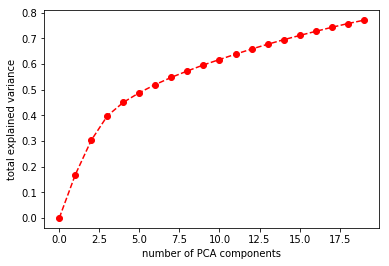

In [181]:
plt.plot(number_comp, explained_var_list,linestyle='--', marker='o', color='r')
plt.xlabel('number of PCA components')
plt.ylabel('total explained variance')
# plt.title('SSE score')

Text(0,0.5,'incremental variance')

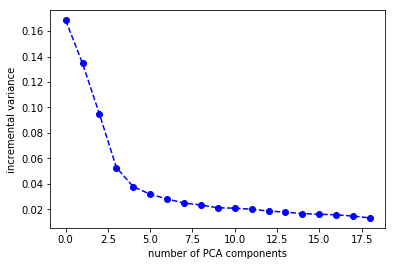

In [183]:
plt.plot(number_comp_diff, explained_var_diff_list, linestyle='--', marker='o', color='b')
plt.xlabel('number of PCA components')
plt.ylabel('incremental variance')
# plt.title('SSE score')

Note: 
- The incremental variance (the variance added by adding one more PCA component) flattens out between 5-6 PCA components, with an added variance of about 3%. 
- Starting from 26 PCA components, the added variance is below 1%.

In [185]:
comp=1
incremental_var = sum([explained_var[i] for i in range(comp)])-sum([explained_var[i] for i in range(comp-1)])
print(incremental_var)

0.16853305967659524


In [186]:
comp=5
incremental_var = sum([explained_var[i] for i in range(comp)])-sum([explained_var[i] for i in range(comp-1)])
print(incremental_var)

0.03768199898196961


In [187]:
comp=6
incremental_var = sum([explained_var[i] for i in range(comp)])-sum([explained_var[i] for i in range(comp-1)])
print(incremental_var)

0.03179379406705318


In [194]:
comp=26
incremental_var = sum([explained_var[i] for i in range(comp)])-sum([explained_var[i] for i in range(comp-1)])
print(incremental_var)

0.009080598814928731


In [195]:
explained_var=sum([explained_var[i] for i in range(26)])
print('Total Variance from first 26 components: ', explained_var) 

Total Variance from first 26 components:  0.850531101061684


In [233]:
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

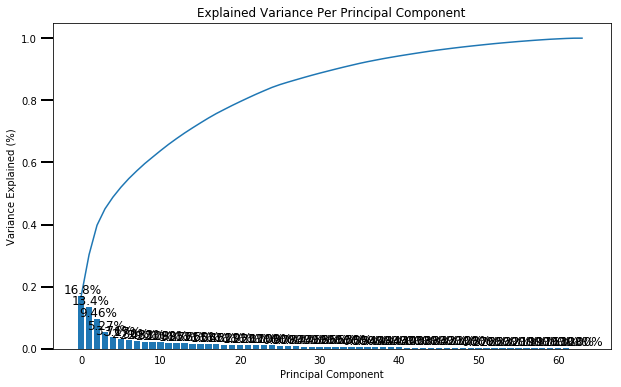

In [234]:
scree_plot(pca)

In [235]:
explained_var40=sum([explained_var[i] for i in range(40)])
print('Total Variance from first 40 components: ', explained_var40) 

Total Variance from first 40 components:  0.938543953619


In [ ]:
# Re-apply PCA to the data while selecting for number of components to retain.


In [196]:
def do_pca(n_components, data):
    '''
    Transforms data using PCA to create n_components, and provides back the results of the
    transformation.

    INPUT: n_components - int - the number of principal components to create
           data - the data you would like to transform

    OUTPUT: pca - the pca object created after fitting the data
            X_pca - the transformed X matrix with new number of components
    '''
    # X = StandardScaler().fit_transform(data)
    X = data
    
    pca = PCA(n_components)
    X_pca = pca.fit_transform(X)
    return pca, X_pca

In [222]:
# PCA with n_components=40
pca, X_pca = do_pca(40, data_scaled)

In [223]:
# apply the same pca transform to the outlier data (no fit)
X_out_pca = pca.transform(data_out_scaled)

In [224]:
X_pca.shape

(792287, 40)

In [225]:
X_out_pca.shape

(98934, 40)

In [197]:
# PCA with n_components=26 (second run)
pca26, X_pca26 = do_pca(26, data_scaled)

In [198]:
# apply the same pca transform to the outlier data (no fit)
X_out_pca26 = pca.transform(data_out_scaled)

In [199]:
X_pca26.shape

(792287, 26)

In [200]:
X_out_pca26.shape

(98934, 64)

### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

- Based on the scree plot shown above, I have done one analysis with 40 components which explains more than 90% of the variance. 
- In a second run, I have investigated the incremental varaince explained by adding one more principal component. Here, one can make the following observations: (i) The incremental variance (the variance added by adding one more PCA component) flattens out between 5-6 PCA components, with an added variance of about 3%. (ii) Starting from 26 PCA components, the added variance is below 1%. At this point, the total explained variance is already as high as 85%. 

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [288]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.


In [201]:
def pca_results(full_dataset, pca):
    '''
    Create a DataFrame of the PCA results
    Includes dimension feature weights and explained variance
    Visualizes the PCA results
    '''

    # Dimension indexing
    dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = full_dataset.keys())
    components.index = dimensions

    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimensions

    # Create a bar plot visualization
    fig, ax = plt.subplots(figsize = (14,8))

    # Plot the feature weights as a function of the components
    components.plot(ax = ax, kind = 'bar');
    ax.set_ylabel("Feature Weights")
    ax.set_xticklabels(dimensions, rotation=0)


    # Display the explained variance ratios
    for i, ev in enumerate(pca.explained_variance_ratio_):
        ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Explained Variance\n          %.4f"%(ev))

    # Return a concatenated DataFrame
    return pd.concat([variance_ratios, components], axis = 1)

,Explained Variance,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PJ_move,PJ_decade,CAMEO_INTL_2015_first_auto,CAMEO_INTL_2015_second_auto
Dimension 1,0.1685,-0.1158,0.0082,-0.2184,0.1431,-0.1107,0.0664,0.0708,0.1635,-0.1097,...,0.2206,0.0417,-0.1684,0.1443,0.1982,0.1362,-0.1074,0.0979,0.2081,-0.1253
Dimension 2,0.1346,0.2612,0.0896,0.0692,-0.2372,0.2341,-0.2054,-0.2282,0.1149,-0.0141,...,0.0853,0.0122,-0.0689,0.0651,0.0871,0.0627,-0.0121,-0.2523,0.0715,0.0035
Dimension 3,0.0947,0.0786,-0.3689,0.1559,-0.1058,0.1007,-0.1887,-0.0993,-0.0426,0.0474,...,0.0451,0.0040,-0.0382,0.0346,0.0462,0.0315,0.0455,-0.1074,0.0273,-0.0087
Dimension 4,0.0527,-0.0423,0.0359,0.0650,-0.0035,-0.0171,-0.1250,0.0822,-0.1069,0.3997,...,0.0842,0.1406,0.0349,0.0541,0.2502,0.0963,0.3990,0.0389,-0.1236,0.0577
Dimension 5,0.0377,-0.0011,0.0069,0.0864,-0.0068,-0.0607,0.0366,-0.0474,-0.0863,0.0600,...,0.0146,-0.4950,-0.4050,0.2191,0.0919,0.1507,0.0558,0.0293,-0.0082,0.0261
Dimension 6,0.0318,0.0002,0.0175,-0.0274,0.0043,-0.0340,0.0194,-0.0245,0.0310,0.0099,...,0.0864,-0.0445,-0.0910,-0.1697,-0.0768,-0.2067,0.0129,0.0127,-0.0718,0.0579
Dimension 7,0.0280,0.0295,-0.0582,0.0544,0.0547,-0.0160,0.0738,0.0411,-0.1853,-0.0200,...,0.0518,0.2098,0.1212,0.0050,0.1096,0.0190,-0.0226,0.1014,0.0185,-0.0734
Dimension 8,0.0248,-0.1524,0.0226,0.0545,-0.0943,0.1427,-0.1245,-0.0547,0.0145,-0.0281,...,-0.1047,-0.0702,0.0311,-0.0157,0.1075,0.0320,-0.0253,-0.1279,-0.0588,0.0401
Dimension 9,0.0234,0.0043,0.0937,0.0727,-0.1209,0.0798,-0.0399,-0.1184,0.0259,-0.0111,...,0.0448,0.1539,0.0803,0.1402,0.0549,0.0596,-0.0101,-0.1323,0.0160,0.0319
Dimension 10,0.0211,0.0431,0.0063,0.0331,-0.0250,0.1220,-0.1078,0.0836,-0.1403,-0.0589,...,-0.0140,-0.2413,-0.1747,-0.4619,-0.0649,-0.2159,-0.0574,-0.0063,0.0481,-0.2256


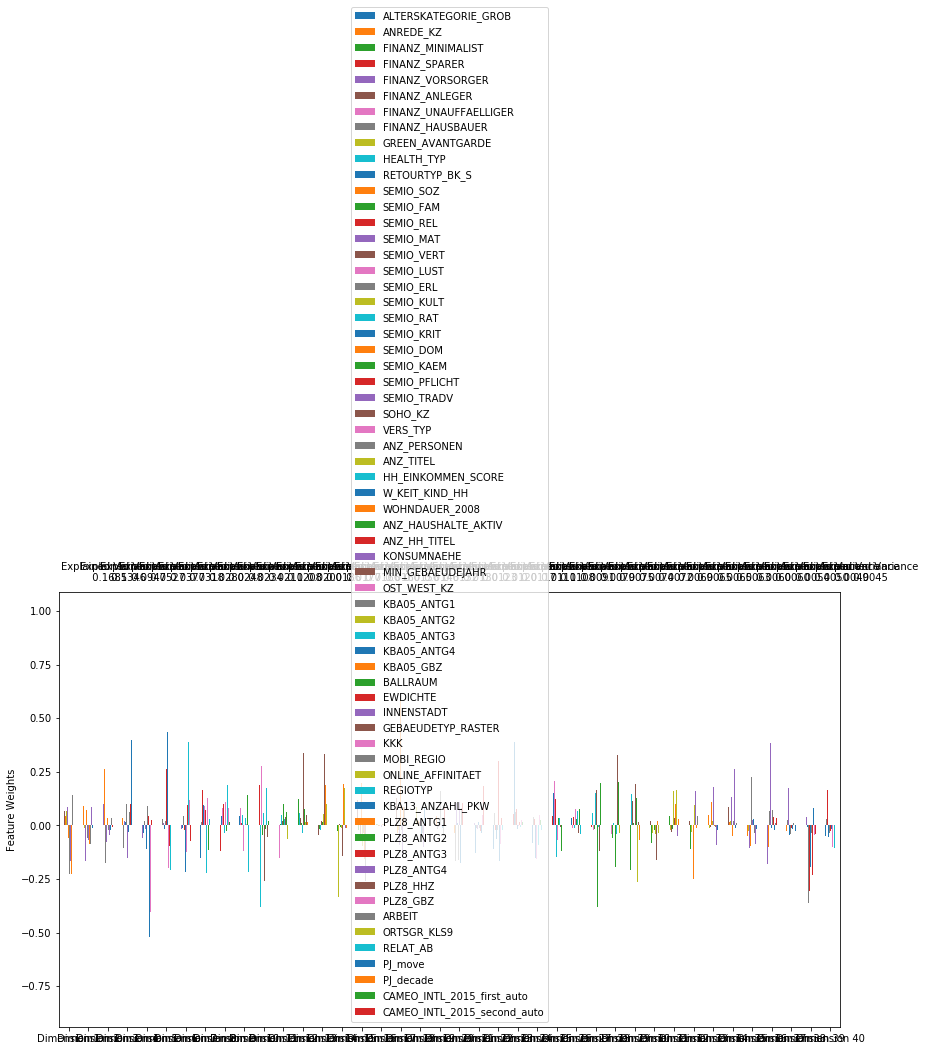

In [255]:
pca_results(data_scaled, pca)

In [202]:
def pca_weights(full_dataset, pca, comp):
    '''
    Print the sorted list of feature weights, for the i-th principal component
    '''

    # Dimension indexing
    dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = full_dataset.keys())
    components.index = dimensions

    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimensions
    
    # PCA results as dataframe
    results = pd.concat([variance_ratios, components], axis = 1)
    results = results.drop('Explained Variance', axis = 1)
    results = results.transpose()
    
    # single out desired i-th principal component
    key = 'Dimension '+str(comp)
    result = pd.DataFrame(results[key].sort_values(ascending=False))

    # Return a concatenated DataFrame
    return result

In [294]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
comp = 1
result = pca_weights(data_scaled, pca, comp)

In [295]:
result.head()

,Dimension 1
PLZ8_ANTG3,0.2275
PLZ8_ANTG4,0.2206
CAMEO_INTL_2015_first_auto,0.2081
HH_EINKOMMEN_SCORE,0.2045
ORTSGR_KLS9,0.1982


In [296]:
result.tail()

,Dimension 1
KBA05_GBZ,-0.2179
FINANZ_MINIMALIST,-0.2184
KBA05_ANTG1,-0.2264
PLZ8_ANTG1,-0.2271
MOBI_REGIO,-0.2429


In [203]:
# Same analysis for just 26 rather than 40 PCA components 
comp = 1
result = pca_weights(data_scaled, pca26, comp)

In [204]:
result.head()

,Dimension 1
PLZ8_ANTG3,0.2275
PLZ8_ANTG4,0.2206
CAMEO_INTL_2015_first_auto,0.2081
HH_EINKOMMEN_SCORE,0.2045
ORTSGR_KLS9,0.1982


In [205]:
result.tail()

,Dimension 1
KBA05_GBZ,-0.2179
FINANZ_MINIMALIST,-0.2184
KBA05_ANTG1,-0.2264
PLZ8_ANTG1,-0.2271
MOBI_REGIO,-0.2429


In [297]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
comp = 2
result = pca_weights(data_scaled, pca, comp)

In [298]:
result.head()

,Dimension 2
ALTERSKATEGORIE_GROB,0.2612
FINANZ_VORSORGER,0.2341
SEMIO_ERL,0.2310
SEMIO_LUST,0.1840
RETOURTYP_BK_S,0.1640


In [299]:
result.tail()

,Dimension 2
SEMIO_PFLICHT,-0.2292
SEMIO_TRADV,-0.2322
FINANZ_SPARER,-0.2372
PJ_decade,-0.2523
SEMIO_REL,-0.2557


In [206]:
# Same analysis for just 26 rather than 40 PCA components 
comp = 2
result = pca_weights(data_scaled, pca26, comp)

In [207]:
result.head()

,Dimension 2
ALTERSKATEGORIE_GROB,0.2612
FINANZ_VORSORGER,0.2341
SEMIO_ERL,0.2310
SEMIO_LUST,0.1840
RETOURTYP_BK_S,0.1640


In [208]:
result.tail()

,Dimension 2
SEMIO_PFLICHT,-0.2292
SEMIO_TRADV,-0.2322
FINANZ_SPARER,-0.2372
PJ_decade,-0.2523
SEMIO_REL,-0.2557


In [300]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
comp = 3
result = pca_weights(data_scaled, pca, comp)

In [301]:
result.head()

,Dimension 3
SEMIO_VERT,0.3456
SEMIO_SOZ,0.2629
SEMIO_FAM,0.2503
SEMIO_KULT,0.2353
FINANZ_MINIMALIST,0.1559


In [302]:
result.tail()

,Dimension 3
SEMIO_RAT,-0.2174
SEMIO_KRIT,-0.2755
SEMIO_DOM,-0.3142
SEMIO_KAEM,-0.3373
ANREDE_KZ,-0.3689


In [209]:
# Same analysis for just 26 rather than 40 PCA components 
comp = 3
result = pca_weights(data_scaled, pca26, comp)

In [210]:
result.head()

,Dimension 3
SEMIO_VERT,0.3456
SEMIO_SOZ,0.2629
SEMIO_FAM,0.2503
SEMIO_KULT,0.2353
FINANZ_MINIMALIST,0.1559


In [211]:
result.tail()

,Dimension 3
SEMIO_RAT,-0.2174
SEMIO_KRIT,-0.2755
SEMIO_DOM,-0.3142
SEMIO_KAEM,-0.3373
ANREDE_KZ,-0.3689


NOTE: Results identical for 26 or 40 components. Of course, system with just 26 features provides numerical advantages. 

### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

In [303]:
print(data_dict)

# Data Dictionary for Identify Customer Segments Data

## Introduction

The data for this project consist of two files:

- Udacity_AZDIAS_Subset.csv: demographics data for the general population of
      Germany; 891211 persons (rows) x 85 features (columns)
- Udacity_CUSTOMERS_Subset.csv: demographics data for customers of a mail-order
      company; 191652 persons (rows) x 85 features (columns)

The columns in the general demographics file and customers data file are the
same. This file documents the features that appear in the data files, sorted in
order of appearance. Sections of this file is based on the level of measurement
of each feature. The file "AZDIAS_Feature_Summary.csv" contains a summary of
feature attributes, including information level, data type, and codes for
missing or unknown values.

### Table of Contents

 1. Person-level features
 2. Household-level features
 3. Building-level features
 4. RR4 micro-cell features
 5. RR3 micro-cell features
 6. Postcode-level fe

Based on the PCA analysis, one can make the following observations: 
- The first component is strongly tied to the group of PLZ8 features that describe macro-cell features. It depends positively on PLZ8_ANTG3 and PLZ8_ANTG4 (i.e., the number of large family houses in the PLZ8 region) and is negatively correlated with PLZ8_ANTG1 (which refers to small family houses). Intuitively, this negative correlation between LARGE family houses (PLZ8_ANTG3, PLZ8_ANTG4) and small family houses (PLZ8_ANTG1) makes sense. 
- The second component depends on the age and some specific personality characteristic. It captures positively sensual-minded (SEMIO_LUST), event-oriented (SEMIO_ERL) people, as negatively opposed to the religious characteristics (SEMIO_REL). It also depends on the financial type of individual, positively with FINANZ_VORSORGER and negatively with FINANZ_SPARER. It strongly captures age, as specified by ALTERSKATEGORIE_GROB (the larger the older) and PJ_decade (the larger the younger) with opposite signs in agrrement with the opposite definitions for age. 
- The third component is strongly tied to the personality characteristics as described by the the group of SEMIO features. It uncovers positive and negative correlations between the personality traits. Namely, it is posititvely weighted with dreamful (VERT), socially-minded (SOZ), and family-minded (FAM) people, but negatively with combative (KAEM), dominant-minded (DOM), and crtitcal-minded people. These two types of characteristics paint an intuitive picture of two opposing types of personalities.  

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [306]:
# Over a number of different cluster counts...

    # run k-means clustering on the data and...
        
    # compute the average within-cluster distances.
    

In [312]:
from sklearn.cluster import KMeans

scores=[]
centers=[]

for kk in range(1,21):
    # Try instantiating a model with k centers
    kmeans = KMeans(kk)

    # Then fit the model to your data using the fit method
    model = kmeans.fit(X_pca)

    # Obtain a score related to the model fit
    # lecture: sklearn score is an indication of how far the points are from the centroids
    labels = model.score(X_pca)
    
    centers.append(kk)
    scores.append(abs(labels))

In [310]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.


Text(0.5,1,'SSE score')

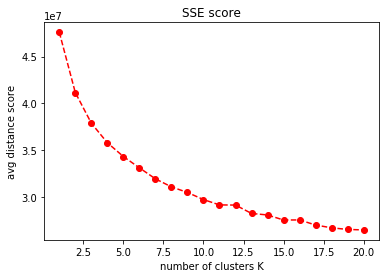

In [313]:
plt.plot(centers, scores,linestyle='--', marker='o', color='r')
plt.xlabel('number of clusters K')
plt.ylabel('avg distance score')
plt.title('SSE score')

In [ ]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.


In [229]:
from sklearn.cluster import KMeans

# Instantiate model with k=5 centers
kk = 5
kmeans = KMeans(kk)

# Fit the model to your data using the fit method
model = kmeans.fit(X_pca)

# Predict the labels (closest cluster) on the same data to show the category that every point belongs to
labels = model.predict(X_pca)

In [230]:
labels_out = model.predict(X_out_pca)

In [231]:
df_labels = pd.DataFrame(data=labels, columns=['Cluster'])
df_labels.head()

,Cluster
0,2
1,4
2,4
3,3
4,1


In [334]:
df_labels['Cluster'].unique()

array([1, 0, 3, 4, 2])

In [232]:
# print relative proportions of clusters
for cc in range(0,5):
    s = df_labels[df_labels['Cluster']==cc]
    percent = len(s)/len(df_labels)*100
    # text = 'Relative size of cluster number ' + str(cc) + ': '
    # print(text, len(s)/len(df_labels)*100)
    print ("Relative size of cluster number {0} in %: {1:.2f}%"
            .format(cc, percent))

Relative size of cluster number 0 in %: 22.27%
Relative size of cluster number 1 in %: 18.37%
Relative size of cluster number 2 in %: 19.52%
Relative size of cluster number 3 in %: 20.33%
Relative size of cluster number 4 in %: 19.51%


In [233]:
df_labels_out = pd.DataFrame(data=labels_out, columns=['Cluster'])
df_labels_out.head()

,Cluster
0,1
1,1
2,1
3,1
4,1


In [234]:
# print relative proportions of clusters
for cc in range(0,5):
    s = df_labels_out[df_labels_out['Cluster']==cc]
    percent = len(s)/len(df_labels_out)*100
    # text = 'Relative size of cluster number ' + str(cc) + ': '
    # print(text, len(s)/len(df_labels)*100)
    print ("Relative size of cluster number {0} in %: {1:.2f}%"
            .format(cc, percent))

Relative size of cluster number 0 in %: 0.15%
Relative size of cluster number 1 in %: 83.88%
Relative size of cluster number 2 in %: 0.61%
Relative size of cluster number 3 in %: 7.38%
Relative size of cluster number 4 in %: 7.98%


NOTE: If we determine the clusters from the clean data (without high-NAN outliers), great majority of outliers is found to be in one specific cluster. 

### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

Trying to strike the balance between precision and simplicity, I choose k=5 clusters. This result is based on the analysis and plot given above showing that the SSE score drops significantly till k=5, but then starts to flatten out. This reasoning is the elbow-criterion, although the elbow is not very pronounced.  

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [235]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')

In [343]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.


In [236]:
# apply preprocessing
customers = clean_data(customers)

In [348]:
# apply transformation: Imputation and standardization with objects fit to general demographics data
# since this was previously done within function transform_data (see above) I will repeat the procedure again here

# replace nan values with mean
imputer = Imputer()
data_out = imputer.fit_transform(azdias_drop_drop)
    
# scale data using StandardScaler
scaler = StandardScaler()
data_out = scaler.fit_transform(data_out)

# apply transformations to customer data
customers = imputer.transform(customers)
customers = scaler.transform(customers)

#customers = pd.DataFrame(data=customers,    # values
#     index=azdias_drop_drop.index,    # 1st column as index
#     columns=azdias_drop_drop.keys())

# apply PCA
customers_pca = pca.transform(customers)

In [237]:
# Use previous imputer and scaler (WITHOUT FIT) 
# I still think that the analysis above was correct. I just had to re-run imputer and scaler on the FULL dataset, 
# because I had not saved these objects previously (see transform_data function)

# apply transformations to customer data
customers = imputer.transform(customers)
customers = scaler.transform(customers)

# apply PCA
customers_pca = pca.transform(customers)

In [238]:
# get cluster assignments for customer data
labels_customers = model.predict(customers_pca)

In [239]:
df_labels_customers = pd.DataFrame(data=labels_customers, columns=['Cluster'])
df_labels_customers.head()

,Cluster
0,3
1,4
2,3
3,2
4,3


In [248]:
# repeat for customer outliers (high NaN ratio)
customers2 = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')
customers_out = get_outlier_data(customers2)
# apply transformations to customer data
customers_out = imputer.transform(customers_out)
customers_out = scaler.transform(customers_out)
# apply PCA
customers_out_pca = pca.transform(customers_out)
# get cluster assignments for customer data
labels_customers_out = model.predict(customers_out_pca)

df_labels_customers_out = pd.DataFrame(data=labels_customers_out, columns=['Cluster'])
df_labels_customers_out.head()

,Cluster
0,3
1,4
2,1
3,1
4,1


In [249]:
print('Shape of original data: ', customers2.shape)
print('Shape of trimmed, clean data (low NaN rows): ', customers.shape)
print('Shape of trimmed, clean data (high NaN rows: Outliers): ', customers_out.shape)

Shape of original data:  (191652, 85)
Shape of trimmed, clean data (low NaN rows):  (140898, 64)
Shape of trimmed, clean data (high NaN rows: Outliers):  (50754, 64)


In [250]:
#check if low-nan dataset and outlier dataset combine together to the full dataset
print('Shape of two data sets correct: ', customers2.shape[0] == (customers_out.shape[0]+customers.shape[0]))

Shape of two data sets correct:  True


In [264]:
percent = 100*(data_out.shape[0]/(data_out.shape[0]+azdias_drop_drop.shape[0]))
print ("Proportion of high-NaN data in general population: {0:.2f}%".format(percent))

Proportion of high-NaN data in general population: 11.10%


In [265]:
percent = 100*(customers_out.shape[0]/(customers_out.shape[0]+customers.shape[0]))
print ("Proportion of high-NaN data in general population: {0:.2f}%".format(percent))

Proportion of high-NaN data in general population: 26.48%


In [251]:
# print relative proportions of clusters
for cc in range(0,5):
    s = df_labels_customers_out[df_labels_customers_out['Cluster']==cc]
    percent = len(s)/len(df_labels_customers_out)*100
    # text = 'Relative size of cluster number ' + str(cc) + ': '
    # print(text, len(s)/len(df_labels)*100)
    print ("Relative size of cluster number {0} in %: {1:.2f}%"
            .format(cc, percent))

Relative size of cluster number 0 in %: 0.10%
Relative size of cluster number 1 in %: 92.44%
Relative size of cluster number 2 in %: 0.04%
Relative size of cluster number 3 in %: 4.75%
Relative size of cluster number 4 in %: 2.67%


### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [ ]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.


In [241]:
def get_cluster_relative_cluster_size(data, k):
    for cc in range(0,k):
        s = data[data['Cluster']==cc]
        percent = len(s)/len(data)*100
        print ("Relative size of cluster number {0} in %: {1:.2f}%"
            .format(cc, percent))

In [354]:
# distribution in general demographic data
get_cluster_relative_cluster_size(df_labels,5)

Relative size of cluster number 0 in %: 19.52%
Relative size of cluster number 1 in %: 19.54%
Relative size of cluster number 2 in %: 22.26%
Relative size of cluster number 3 in %: 20.32%
Relative size of cluster number 4 in %: 18.36%


In [355]:
# distribution in customer data
get_cluster_relative_cluster_size(df_labels_customers,5)

Relative size of cluster number 0 in %: 21.42%
Relative size of cluster number 1 in %: 2.13%
Relative size of cluster number 2 in %: 17.97%
Relative size of cluster number 3 in %: 55.25%
Relative size of cluster number 4 in %: 3.23%


In [243]:
def get_cluster_relative_cluster_size2(data, k):
    cluster_number=[]
    cluster_size=[]
    for cc in range(0,k):
        s = data[data['Cluster']==cc]
        percent = len(s)/len(data)*100
        print ("Relative size of cluster number {0} in %: {1:.2f}%"
            .format(cc, percent))
        cluster_size.append(percent)
        cluster_number.append(cc)
    
    result = pd.DataFrame(cluster_size, index=cluster_number)
    result.columns = ['size']

    return result    

In [421]:
# distribution in general demographic data
result_population = get_cluster_relative_cluster_size2(df_labels,5)

Relative size of cluster number 0 in %: 19.52%
Relative size of cluster number 1 in %: 19.54%
Relative size of cluster number 2 in %: 22.26%
Relative size of cluster number 3 in %: 20.32%
Relative size of cluster number 4 in %: 18.36%


In [422]:
# distribution in general demographic data
result_customer = get_cluster_relative_cluster_size2(df_labels_customers,5)

Relative size of cluster number 0 in %: 21.42%
Relative size of cluster number 1 in %: 2.13%
Relative size of cluster number 2 in %: 17.97%
Relative size of cluster number 3 in %: 55.25%
Relative size of cluster number 4 in %: 3.23%


In [423]:
result_population

,size
0,19.517927
1,19.535724
2,22.261882
3,20.324832
4,18.359635


In [424]:
result_customer

,size
0,21.416202
1,2.130619
2,17.971156
3,55.247058
4,3.234964


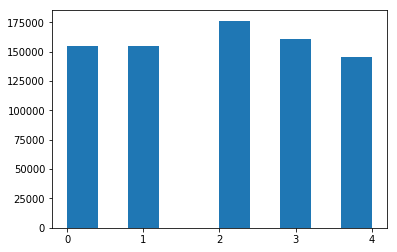

In [425]:
# plot histogram of general population
plt.hist(df_labels)
plt.show()

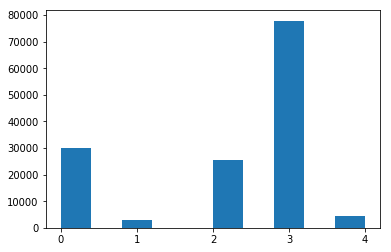

In [426]:
# plot histogram of customers
plt.hist(df_labels_customers)
plt.show()

In [ ]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?


In [ ]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?


In [435]:
cluster_centers = pd.DataFrame(model.cluster_centers_)
cluster_centers_orig = pd.DataFrame(pca.inverse_transform(model.cluster_centers_), columns=azdias_drop_drop.keys())

In [438]:
# cluster characteristics in terms of PCA components 
cluster_centers.head()

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,-3.013975,1.627409,-1.928517,0.229864,0.107453,0.006754,0.068456,-0.140468,-0.060054,-0.047699,...,-0.037665,0.032744,0.011378,-0.002432,-0.019070,0.007859,-0.147420,-0.008228,-0.067377,0.043843
1,4.295702,-1.714817,-0.257651,0.148952,0.039693,-0.015625,-0.077629,0.008162,0.108593,-0.007524,...,-0.031031,0.009422,0.008561,0.017607,-0.000830,0.027384,0.030803,-0.042746,-0.065343,0.017510
2,2.206503,3.285343,0.609093,-0.277339,-0.051229,0.010731,0.117374,-0.123928,-0.060896,0.076366,...,0.038482,-0.011373,0.012164,0.007716,-0.013799,-0.025378,-0.020231,0.023298,0.050536,-0.008872
3,-2.891912,-0.070895,2.302375,0.045276,0.018743,-0.088035,0.069972,0.124619,-0.082833,0.026357,...,-0.003991,-0.010342,-0.004077,0.009411,0.039696,0.000434,0.088104,0.024282,0.038354,-0.048891
4,-0.841935,-3.810136,-0.963807,-0.116717,-0.115107,0.093923,-0.209955,0.152918,0.113819,-0.063079,...,0.030823,-0.019592,-0.031444,-0.035934,-0.006068,-0.007208,0.050896,-0.000895,0.037423,-0.000346


In [439]:
# cluster characteristics in terms of original features
cluster_centers_orig.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PJ_move,PJ_decade,CAMEO_INTL_2015_first_auto,CAMEO_INTL_2015_second_auto
0,0.640653,0.863733,0.480578,-0.557023,0.488343,-0.091867,-0.404063,-0.289360,0.341878,-0.125867,...,-0.566816,-0.105055,0.436796,-0.361619,-0.477001,-0.337504,0.341360,-0.449601,-0.562542,0.350106
1,-0.964219,0.014129,-1.101999,1.057640,-0.910186,0.679210,0.748776,0.554173,-0.347078,0.114948,...,0.813136,0.156089,-0.613635,0.507399,0.737070,0.480618,-0.336883,0.860571,0.772053,-0.576064
2,0.660324,0.056146,-0.163442,-0.536631,0.605142,-0.621902,-0.690247,0.682679,-0.377918,-0.034636,...,0.767800,0.117541,-0.608940,0.500850,0.650371,0.484857,-0.371612,-0.661097,0.749108,-0.268914
3,0.467086,-0.929021,1.084261,-0.702962,0.552176,-0.710851,-0.464957,-0.688048,0.382943,0.011963,...,-0.540862,-0.101392,0.407666,-0.318150,-0.432888,-0.302759,0.364770,-0.509095,-0.557431,0.311614
4,-0.972650,0.027445,-0.340310,0.895507,-0.895561,0.915986,0.984400,-0.348233,0.040252,0.040200,...,-0.595141,-0.084730,0.475853,-0.410736,-0.586812,-0.405513,0.042428,0.927337,-0.514941,0.222044


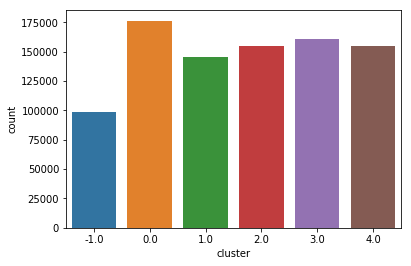

In [255]:
# Distribution of general population
# distribution is relatively homogeneous (up to slighlty smaller outlier cluster)
labels1=pd.DataFrame(labels)
labels1.columns=['cluster']

# cluster -1 includes those rows having too many NaNs (larger than threshold)
labels2=pd.DataFrame(-1*np.ones([labels_out.shape[0],1]))
labels2.columns=['cluster']

labels=pd.concat([labels1,labels2],axis=0)

import seaborn as sns
sns.countplot(x='cluster', data=labels)

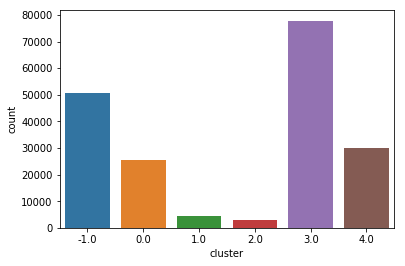

In [259]:
# Distribution of customer population
# outlier segment (lots of NaNs) makes up second largest fraction among customer data 
labels1=pd.DataFrame(labels_customers)
labels1.columns=['cluster']

# cluster -1 includes those rows having too many NaNs (larger than threshold)
labels2=pd.DataFrame(-1*np.ones([labels_customers_out.shape[0],1]))
labels2.columns=['cluster']

labels=pd.concat([labels1,labels2],axis=0)

import seaborn as sns
sns.countplot( x='cluster', data=labels)

In [266]:
percent = 100*(data_out.shape[0]/(data_out.shape[0]+azdias_drop_drop.shape[0]))
print ("Proportion of high-NaN data in general population: {0:.2f}%".format(percent))

Proportion of high-NaN data in general population: 11.10%


In [267]:
percent = 100*(customers_out.shape[0]/(customers_out.shape[0]+customers.shape[0]))
print ("Proportion of high-NaN data in general population: {0:.2f}%".format(percent))

Proportion of high-NaN data in general population: 26.48%


### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

- Cluster 3 is strongly overrepresented as compared to the geenral population which is fairly homogeneous across the different clusters. It makes up about 55% in the customer population, but only 20% in the general population. Therefore, Cluster 3 should be our target cluster. 
The centroid of cluster 3 lies in the positive region of the first PCA, at the origin (zero) of the second PCA feature and in the negative region of the third PCA. Therefore, the target audience seems to live in areas with relatively large family houses (as described by the first PCA variable) and shows personality characteristics that can be read off from PCA3 (which depends mostly on the original SEMIO features). 
- Conversely, clusters 1 and 4 are stronlgy underrepresented. They only make up 2% and 3% of the customer population, while accounting for about 20% each in the general population. 
The centroid of cluster 4 lies at the origin of PCA1 and PCA3, but shows a strong negative number on PCA2. Accordingly, cluster 4 refers to a group of relatively young people that should not be targeted primarily as customers.  
- Rows with a large fraction of NaN values (referred to as outliers above) have been introduced as seprate cluster. This cluster has been found to make up a much larger portion of the population within our customers (26%) as compared to the general population where it accounts for about 11% only.  

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.